# Checkpoint 1

### Importy

In [61]:
import pandas as pd
import numpy as np
import json
import ast

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import pickle
import gensim

import nltk, re
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize

from gensim.models import Word2Vec
from sklearn.decomposition import PCA

nltk.download('stopwords')
nltk.download('punkt')

from utils import read_config
from pandas.io.json import json_normalize

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/hylomorph/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/hylomorph/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Czytanie konfiguracji z pliku
Wczytywane sƒÖ klucze do API YouTubowego, kt√≥re nie powinny byƒá udostƒôpniane publicznie

In [2]:
config = read_config("config.json")
config['dataset_path'] = Path(config['dataset_path'])

### Por√≥wnanie plik√≥w zawierajƒÖcych kategorie


In [3]:
!diff data/GB_category_id.json data/US_category_id.json

3c3
<  "etag": "\"m2yskBQFythfE4irbTIeOgYYfBU/1v2mrzYSYG6onNLt2qTj13hkQZk\"",
---
>  "etag": "\"m2yskBQFythfE4irbTIeOgYYfBU/S730Ilt-Fi-emsQJvJAAShlR6hM\"",
161a162,171
>     "assignable": true
>    }
>   },
>   {
>    "kind": "youtube#videoCategory",
>    "etag": "\"m2yskBQFythfE4irbTIeOgYYfBU/SalkJoBWq_smSEqiAx_qyri6Wa8\"",
>    "id": "29",
>    "snippet": {
>     "channelId": "UCBR8-60-B28hp2BmDPdntcQ",
>     "title": "Nonprofits & Activism",


W pliku wystƒôpujƒÖ tylko dwie r√≥≈ºnice: `etag`, kt√≥ry okre≈õla identyfikator zapytania. Jest to w naszym przypadku r√≥≈ºnica, kt√≥ra nie ma znaczenia. Plik `data/US_category_id.json` zawiera za to o jednƒÖ¬†kategoriƒô wiƒôcej, ni≈º brytyjski odpowiednik. Dodatkowa kategoria to `Nonprofits & Activism`. Poniewa≈º w pozosta≈Çych przypadkach pliki sƒÖ jednakowe, to mo≈ºna u≈ºyƒá pliku `data/US_category_id.json` jako ≈∫r√≥d≈Ço informacji o kategoriach dla ameryka≈Ñskich i brytyjskich kart trending.

# Wstƒôpne statystyki

### Wczytywanie danych
Dane wczytywane sƒÖ za pomocƒÖ biblioteki Pandas. Plik CSV jest odzielany za pomocƒÖ ';'. Dodatkowo przetwarzane sƒÖ daty z tekstu na znaczniki czasowe. Kolumna `trending_date` nie mo≈ºe byƒá automatycznie konwertowana, poniewa≈º posiada niestandardowy format daty: `rok.dzie≈Ñ.miesiƒÖc` (odzielony kropkami, gdyby by≈Ç odzielony uko≈õnikami `\`, to by≈Ç by to standardowy format ameryka≈Ñski).

Poniewa≈º informacje o kategoriach sƒÖ wsp√≥lne (jak by≈Ço por√≥wnywane wcze≈õniej) to obie tabele sƒÖ ≈ÇƒÖczone w jednƒÖ. Aby mo≈ºna odr√≥≈ºniƒá informacjƒô o ≈∫r√≥dle danych, dodana zosta≈Ça kolumna `origin` zawierajƒÖca warto≈õci `US` lub `GB`.

In [4]:
def load_csv(path, origin):
    df = pd.read_csv(path, sep=';', parse_dates=['publish_time'])
    df.columns = list(map(str.strip, df.columns))
    df['trending_date'] = pd.to_datetime(df.trending_date, format='%y.%d.%m')
    df['origin'] = origin
    return df


us_videos_df = load_csv(config['dataset_path'] / 'US_videos_5p.csv', 'US')
gb_videos_df = load_csv(config['dataset_path'] / 'GB_videos_5p_utf8.csv', 'GB')

videos_df = pd.concat([us_videos_df, gb_videos_df]).reset_index(drop=True)
# videos_df['origin'] = videos_df['origin'].astype('category')

# Pierwsze 3 i ostatnie 3 warto≈õci
videos_df.iloc[[0,1,2,-3,-2,-1]]

video_id trending_date  \
0      2kyS6SvSYSE    2017-11-14   
1      1ZAPwfrtAFY    2017-11-14   
2      5qpjK5DgCt4    2017-11-14   
79862  Il-an3K9pjg    2018-06-14   
79863      #NAZWA?    2018-06-14   
79864  4YFo4bdMO8Q    2018-06-14   

                                                   title  \
0                     WE WANT TO TALK ABOUT OUR MARRIAGE   
1      The Trump Presidency: Last Week Tonight with J...   
2      Racist Superman | Rudy Mancuso, King Bach & Le...   
79862                 Anne-Marie - 2002 [Official Video]   
79863  Eleni Foureira - Fuego - Cyprus - LIVE - First...   
79864  KYLE - Ikuyo feat.  2 Chainz & Sophia Black [A...   

                 channel_title  category_id              publish_time  \
0                 CaseyNeistat          NaN 2017-11-13 17:13:01+00:00   
1              LastWeekTonight          NaN 2017-11-13 07:30:00+00:00   
2                 Rudy Mancuso          NaN 2017-11-12 19:05:24+00:00   
79862               Anne-Marie          NaN 2018-05-08 11:05:08+00:00   
79863  Eurovision Song Contest          NaN 2018-05-08 20:32:32+00:00   
79864           SuperDuperKyle          NaN 2018-05-11 04:06:35+00:00   

                                                    tags     views   likes  \
0                                        SHANtell martin    748374   57527   
1      last week tonight trump presidency|"last week ...   2418783   97185   
2      racist superman|"rudy"|"mancuso"|"king"|"bach"...   3191434  146033   
79862  anne|"marie"|"anne-marie"|"2002"|"two thousand...  29641412  394830   
79863  Eurovision Song Contest|"2018"|"Lisbon"|"Cypru...  14317515  151870   
79864  Kyle|"SuperDuperKyle"|"Ikuyo"|"2 Chainz"|"Soph...    607552   18271   

       dislikes  comment_count  \
0          2966          15954   
1          6146          12703   
2          5339           8181   
79862      8892          19988   
79863     45875          26766   
79864       274           1423   

                                       thumbnail_link  comments_disabled  \
0      https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg              False   
1      https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg              False   
2      https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg              False   
79862  https://i.ytimg.com/vi/Il-an3K9pjg/default.jpg              False   
79863  https://i.ytimg.com/vi/-DRsfNObKIQ/default.jpg              False   
79864  https://i.ytimg.com/vi/4YFo4bdMO8Q/default.jpg              False   

       ratings_disabled  video_error_or_removed  \
0                 False                   False   
1                 False                   False   
2                 False                   False   
79862             False                   False   
79863             False                   False   
79864             False                   False   

                                             description origin  
0      SHANTELL'S CHANNEL - https://www.youtube.com/s...     US  
1      One year after the presidential election, John...     US  
2      WATCH MY PREVIOUS VIDEO ‚ñ∂  SUBSCRIBE ‚ñ∫ https:/...     US  
79862  Get 2002 by Anne-Marie HERE ‚ñ∂ http://ad.gt/200...     GB  
79863  Eleni Foureira represented Cyprus at the first...     GB  
79864  Debut album 'Light of Mine' out now: http://ky...     GB

### Podstawowe informacje o kolumnach

In [5]:
videos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79865 entries, 0 to 79864
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   video_id                79865 non-null  object             
 1   trending_date           79865 non-null  datetime64[ns]     
 2   title                   79865 non-null  object             
 3   channel_title           79865 non-null  object             
 4   category_id             3932 non-null   float64            
 5   publish_time            79865 non-null  datetime64[ns, UTC]
 6   tags                    79865 non-null  object             
 7   views                   79865 non-null  int64              
 8   likes                   79865 non-null  int64              
 9   dislikes                79865 non-null  int64              
 10  comment_count           79865 non-null  int64              
 11  thumbnail_link          79865 non-null  o

### Podstawowe informacje czasowe

Jak du≈ºo film√≥w by≈Ço popularnych w kolejnych dniach i w danych regionach.

In [6]:
count_df = videos_df.groupby(['trending_date', 'origin'], as_index=False, sort=True).video_id.count()

px.line(count_df, x='trending_date', y='video_id', color='origin', title="Ilo≈õƒá¬†popularnych film√≥w w czasie",
        labels={"origin": "Region", "video_id": "Ilo≈õƒá film√≥w", "trending_date": "Czas"})

Na wykresie widaƒá, ≈ºe dane zaczynajƒÖ¬†siƒô od 14 listopada 2017 roki, a ko≈ÑczƒÖ¬†siƒô 14 czerwca 2018 roku. Dane pokrywajƒÖ 7 miesiƒôcy. Widaƒá, ≈ºe w po≈Çowie marca spad≈Ça znaczƒÖco liczba popularnych film√≥w dla kolejnych dni. 

## Popsute ID film√≥w

### Zliczanie ID film√≥w

Zliczamy ID film√≥w aby sprawdziƒá, czy wystƒôpujƒÖ bardzo popularne filmy. Okaza≈Ço siƒô jednak, ≈ºe najczƒôstrzym ID filmu jest `#NAZWA?`. Pozatym widaƒá, ≈ºe niekt√≥re filmy sƒÖ popularne przez wiele dni. Nale≈ºy jednak sprawdziƒá, czy te same filmy nie sƒÖ popularne w r√≥≈ºnych krajach w tym samym dniu (liczone dwa razy).

In [7]:
videos_df.video_id.value_counts()

#NAZWA?        727
8h--kFui1JA     66
vjSohj-Iclc     62
VYOjWnS4cMY     61
l884wKofd54     61
              ... 
B3jbfLe2ZZs      1
tXoJTxPLrKM      1
I5vjN78Eroo      1
67LnlgA_Too      1
aydY1eiGjgs      1
Name: video_id, Length: 8511, dtype: int64

### Naprawianie zepsutych ID

Pobrali≈õmy dane za pomocƒÖ klasy `YTDownloader` z pliku `utils.py` a nastƒôpnie zapisali≈õmy je w formacie `pickle` do p√≥≈∫niejszego wykorzystania. Aby pobraƒá unikalne ID filmu u≈ºyli≈õmy `Search YouTube API`, gdzie wyszukiwali≈õmy filmy o konretnym tytule i od konretnego autora.

In [8]:
def load_missing_ids(path):
    with open(path, 'rb') as fh:
        return{k: v['items'][0]['id']['videoId'] for k, v in pickle.load(fh).items()}

us_missing = load_missing_ids(config['dataset_path'] / 'us_missing_id.pkl')
gb_missing = load_missing_ids(config['dataset_path'] / 'gb_missing_id.pkl')

for (title, channel), idx in {**us_missing, **gb_missing}.items():
    videos_df.loc[(videos_df.title == title) & (videos_df.channel_title == channel), 'video_id'] = idx 

Ponowne wyszukanie film√≥w o ID `#NAZWA?` nie daje wynik√≥w. Skutecznie wype≈Çniono brakujƒÖce ID.

In [9]:
videos_df[videos_df.video_id == '#NAZWA?']

Empty DataFrame
Columns: [video_id, trending_date, title, channel_title, category_id, publish_time, tags, views, likes, dislikes, comment_count, thumbnail_link, comments_disabled, ratings_disabled, video_error_or_removed, description, origin]
Index: []

### Ilo≈õƒá unikalnych film√≥w
MajƒÖc naprawione ID film√≥w mo≈ºna policzyƒá ile unikalnych film√≥w jest zawartych w danych

print("Liczba unikalnych film√≥w:", videos_df.video_id.nunique())

In [11]:
Zobaczmy teraz podstwowe statystyki film√≥w. Pytanie, czy informacje o liczbie kometarzy, polubie≈Ñ itp sƒÖ r√≥≈ºne dla r√≥≈ºnych dni tego samego filmu, czy sƒÖ jednakowe. Dla por√≥wnania sprawdzimy 12 najpopularniejszych film√≥w.

8h--kFui1JA    66
vjSohj-Iclc    62
VYOjWnS4cMY    61
l884wKofd54    61
BspHjvU11y4    60
5GHXEGz3PJg    59
UUkn-enk2RU    59
zxwfDlhJIpw    59
CX11yw6YL1w    57
vjI4Alon-3Q    56
tJfDBSWYqU8    56
oWw1BcFhk-k    56
Name: video_id, dtype: int64

top_10_videos = videos_df.video_id.value_counts()[:12]
top_10_videos

In [12]:
Ciekawe obserwacje: 
- Ten sam film ma informacjƒô o kategorii, ale tylko w jednym rekordzie, pozosta≈Çe sƒÖ wyczyszczone. Nale≈ºy je uzupe≈Çniƒá, co jest niskim kosztem.
- Te same filmy sƒÖ popularne w GB oraz US

video_id trending_date                            title  \
32555  5GHXEGz3PJg    2018-05-04  Florence + The Machine - Hunger   
72945  5GHXEGz3PJg    2018-05-04  Florence + The Machine - Hunger   
32759  5GHXEGz3PJg    2018-05-05  Florence + The Machine - Hunger   
73114  5GHXEGz3PJg    2018-05-05  Florence + The Machine - Hunger   
32968  5GHXEGz3PJg    2018-05-06  Florence + The Machine - Hunger   

             channel_title  category_id              publish_time  \
32555  FlorenceMachineVEVO         10.0 2018-05-03 18:35:00+00:00   
72945  FlorenceMachineVEVO          NaN 2018-05-03 18:35:00+00:00   
32759  FlorenceMachineVEVO          NaN 2018-05-03 18:35:00+00:00   
73114  FlorenceMachineVEVO          NaN 2018-05-03 18:35:00+00:00   
32968  FlorenceMachineVEVO          NaN 2018-05-03 18:35:00+00:00   

                                                    tags    views  likes  \
32555  Florence|"The"|"Machine"|"Hunger"|"Virgin"|"EM...   388954  41427   
72945  Florence|"The"|"Machine"|"Hunger"|"Virgin"|"EM...   388954  41428   
32759  Florence|"The"|"Machine"|"Hunger"|"Virgin"|"EM...  1079622  70900   
73114  Florence|"The"|"Machine"|"Hunger"|"Virgin"|"EM...  1079622  70901   
32968  Florence|"The"|"Machine"|"Hunger"|"Virgin"|"EM...  1651724  85332   

       dislikes  comment_count  \
32555       214           2557   
72945       214           2557   
32759       604           3720   
73114       604           3720   
32968       887           4101   

                                       thumbnail_link  comments_disabled  \
32555  https://i.ytimg.com/vi/5GHXEGz3PJg/default.jpg              False   
72945  https://i.ytimg.com/vi/5GHXEGz3PJg/default.jpg              False   
32759  https://i.ytimg.com/vi/5GHXEGz3PJg/default.jpg              False   
73114  https://i.ytimg.com/vi/5GHXEGz3PJg/default.jpg              False   
32968  https://i.ytimg.com/vi/5GHXEGz3PJg/default.jpg              False   

       ratings_disabled  video_error_or_removed  \
32555             False                   False   
72945             False                   False   
32759             False                   False   
73114             False                   False   
32968             False                   False   

                                             description origin  
32555  HungerDirected by AG RojasProduced by Park Pic...     US  
72945  HungerDirected by AG RojasProduced by Park Pic...     GB  
32759  HungerDirected by AG RojasProduced by Park Pic...     US  
73114  HungerDirected by AG RojasProduced by Park Pic...     GB  
32968  HungerDirected by AG RojasProduced by Park Pic...     US

top_10_df = videos_df[videos_df.video_id.isin(top_10_videos.index)].sort_values(['video_id','trending_date'])
top_10_df.head()

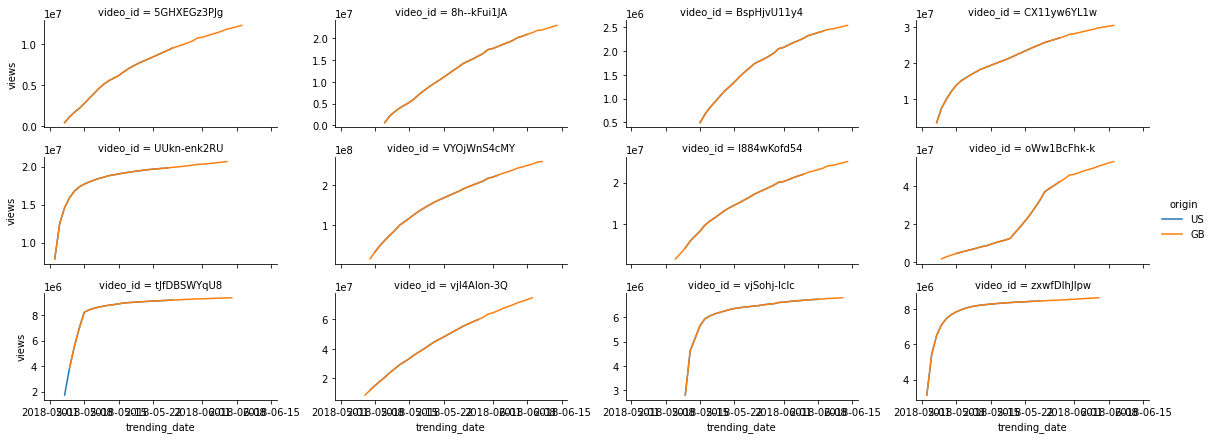

In [13]:
Na poni≈ºszych wykresach widaƒá, ≈ºe liczba wy≈õwietle≈Ñ zwiƒôksza siƒô w czasie. Najprawdpodobniej nale≈ºy braƒá najwiƒôkszƒÖ warto≈õƒá dla ka≈ºdego filmu (bo wy≈õwietle≈Ñ w czasie nie ubywa). Widaƒá, te≈º, ≈ºe US oraz GB nachodzƒÖ na siebie, dlatego te dane sƒÖ globalne (niezale≈ºne od regionu). Jednak≈ºe, nale≈ºy zauwa≈ºyƒá, ≈ºe w przypadku filmu w lewym dolnym rogu US i GB nie na chodzƒÖ na siebie idealnie (wystaje US na poczƒÖtku). Jest to zwiƒÖzane z faktem, ≈ºe film by≈Ç popularny w GB dzie≈Ñ p√≥≈∫niej ni≈º w US, co jest ciekawe. Pytanie, czy nale≈ºy zrobiƒá cechƒô: d≈Çugo≈õƒá popularno≈õci zale≈ºnƒÖ¬†od regionu, czy absolutnƒÖ. 

sns.relplot(data=top_10_df, kind='line', x='trending_date', y='views', col='video_id', hue='origin',
            col_wrap=4, height=2, aspect=2, facet_kws=dict(sharey=False))

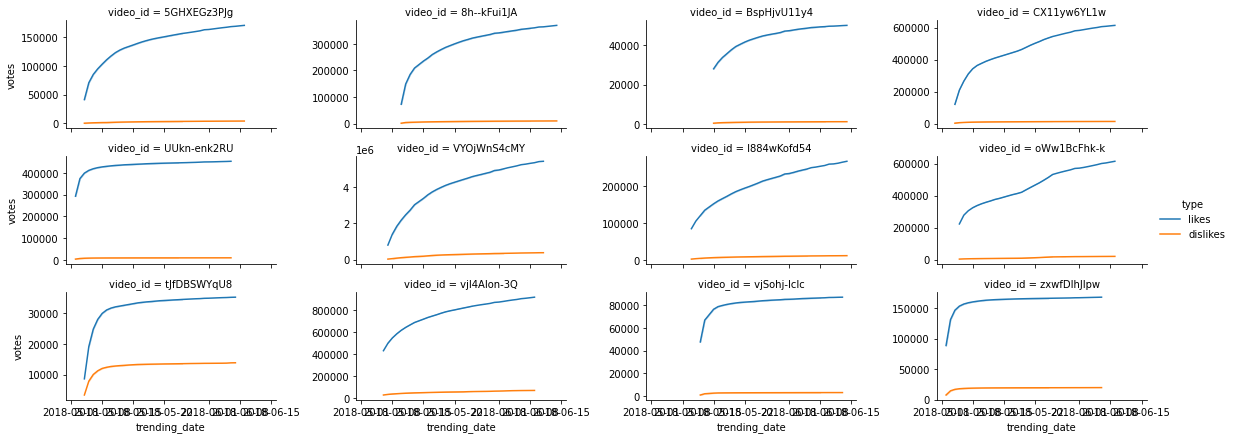

In [14]:
Podobne charakterystyki mo≈ºna zaobserwowaƒá dla liczby ≈Çapek w g√≥rƒô oraz d√≥≈Ç. Na pewno warto dodaƒá cechƒô: stosunek ≈Çapek w g√≥rƒô do wszystkich ≈Çapek (w g√≥rƒô i d√≥≈Ç), wtedy metryka bƒôdzie od 0 do 1 (praktycznie niemo≈ºliwe, bo wiƒôkszo≈õƒá film√≥w zawsze zdobƒôdzie jakƒÖ≈õ ≈Çapkƒô w d√≥≈Ç).

In [10]:
melted_df = top_10_df.melt(id_vars=['video_id', 'trending_date', 'origin'], value_vars=['likes', 'dislikes'], value_name='votes', var_name='type')
sns.relplot(data=melted_df, kind='line', x='trending_date', y='votes', col='video_id', hue='type',
            col_wrap=4, height=2, aspect=2, facet_kws=dict(sharey=False))

Liczba unikalnych film√≥w: 8606


## Statystyki i wykresy

Rozk≈Çady warto≈õci odtworze≈Ñ, lik√≥w, dislik√≥w i komentarzy

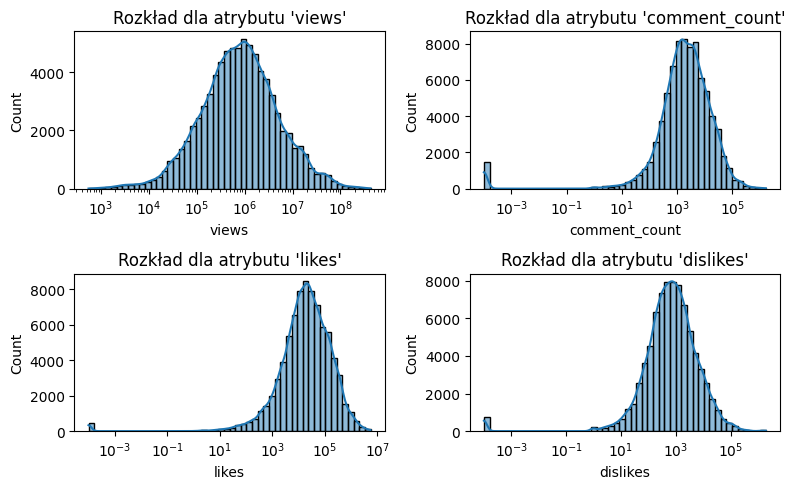

In [15]:
columns = np.array([['views', 'comment_count'], ['likes', 'dislikes']])
# Replace 0s for log scale
plot_df = videos_df[columns.ravel()].replace(0, 0.0001)
fig, ax = plt.subplots(2,2, figsize=(8,5), dpi=100) 

for xy, col in np.ndenumerate(columns):
    g = sns.histplot(plot_df, x=col, kde=True, log_scale=True, ax=ax[xy], bins=50)
    g.set(title=f'Rozk≈Çad dla atrybutu \'{col}\'')

fig.tight_layout()
plt.show()

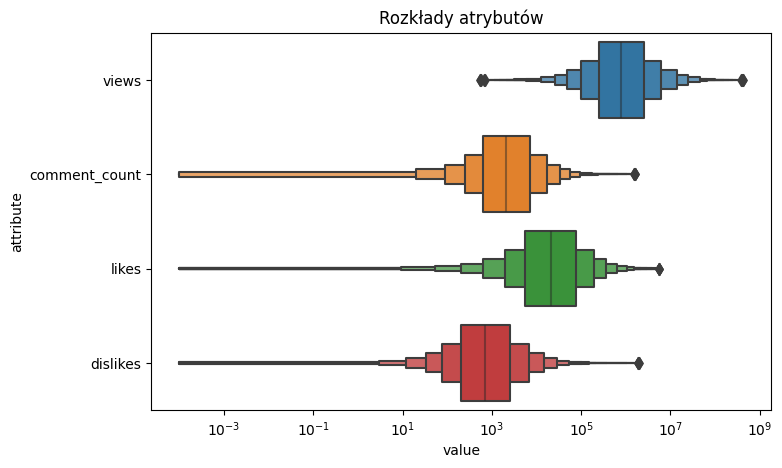

In [16]:
fig, ax = plt.subplots(figsize=(8,5), dpi=100)
g = sns.boxenplot(data=plot_df.melt(var_name='attribute'), x='value', y='attribute')
g.set(xscale='log', title="Rozk≈Çady atrybut√≥w")
plt.show()

≈ÅƒÖczenie film√≥w z informacjƒÖ o kategoriach

In [17]:
# Read categories
with open(config['dataset_path'] / 'US_category_id.json', 'r') as f:
    us_categories = json.load(f)['items']

df_us_categories = pd.DataFrame(us_categories)
df_us_categories = df_us_categories.join(json_normalize(df_us_categories['snippet'].apply(lambda x: ast.literal_eval(str(x))).tolist()).add_prefix('snippet_'))
df_us_categories.drop(columns=['snippet', 'kind', 'etag', 'snippet_channelId', 'snippet_assignable'], inplace=True)
df_us_categories['id'] = df_us_categories['id'].astype('float64')
df_us_categories.rename(columns={'snippet_title': 'category_text'}, inplace=True)

df_us_categories.head(5)

<ipython-input-17-da03daf8be38>:6: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



id     category_text
0   1.0  Film & Animation
1   2.0  Autos & Vehicles
2  10.0             Music
3  15.0    Pets & Animals
4  17.0            Sports

In [18]:
# Join data information
videos_df_merged = videos_df.merge(df_us_categories, left_on='category_id', right_on='id', how='left')
videos_df_merged.drop(columns=['id'], inplace=True)
videos_df_merged.iloc[[0,1,2,-3,-2,-1]]

video_id trending_date  \
0      2kyS6SvSYSE    2017-11-14   
1      1ZAPwfrtAFY    2017-11-14   
2      5qpjK5DgCt4    2017-11-14   
79862  Il-an3K9pjg    2018-06-14   
79863  eDSgs6syrgg    2018-06-14   
79864  4YFo4bdMO8Q    2018-06-14   

                                                   title  \
0                     WE WANT TO TALK ABOUT OUR MARRIAGE   
1      The Trump Presidency: Last Week Tonight with J...   
2      Racist Superman | Rudy Mancuso, King Bach & Le...   
79862                 Anne-Marie - 2002 [Official Video]   
79863  Eleni Foureira - Fuego - Cyprus - LIVE - First...   
79864  KYLE - Ikuyo feat.  2 Chainz & Sophia Black [A...   

                 channel_title  category_id              publish_time  \
0                 CaseyNeistat          NaN 2017-11-13 17:13:01+00:00   
1              LastWeekTonight          NaN 2017-11-13 07:30:00+00:00   
2                 Rudy Mancuso          NaN 2017-11-12 19:05:24+00:00   
79862               Anne-Marie          NaN 2018-05-08 11:05:08+00:00   
79863  Eurovision Song Contest          NaN 2018-05-08 20:32:32+00:00   
79864           SuperDuperKyle          NaN 2018-05-11 04:06:35+00:00   

                                                    tags     views   likes  \
0                                        SHANtell martin    748374   57527   
1      last week tonight trump presidency|"last week ...   2418783   97185   
2      racist superman|"rudy"|"mancuso"|"king"|"bach"...   3191434  146033   
79862  anne|"marie"|"anne-marie"|"2002"|"two thousand...  29641412  394830   
79863  Eurovision Song Contest|"2018"|"Lisbon"|"Cypru...  14317515  151870   
79864  Kyle|"SuperDuperKyle"|"Ikuyo"|"2 Chainz"|"Soph...    607552   18271   

       dislikes  comment_count  \
0          2966          15954   
1          6146          12703   
2          5339           8181   
79862      8892          19988   
79863     45875          26766   
79864       274           1423   

                                       thumbnail_link  comments_disabled  \
0      https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg              False   
1      https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg              False   
2      https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg              False   
79862  https://i.ytimg.com/vi/Il-an3K9pjg/default.jpg              False   
79863  https://i.ytimg.com/vi/-DRsfNObKIQ/default.jpg              False   
79864  https://i.ytimg.com/vi/4YFo4bdMO8Q/default.jpg              False   

       ratings_disabled  video_error_or_removed  \
0                 False                   False   
1                 False                   False   
2                 False                   False   
79862             False                   False   
79863             False                   False   
79864             False                   False   

                                             description origin category_text  
0      SHANTELL'S CHANNEL - https://www.youtube.com/s...     US           NaN  
1      One year after the presidential election, John...     US           NaN  
2      WATCH MY PREVIOUS VIDEO ‚ñ∂  SUBSCRIBE ‚ñ∫ https:/...     US           NaN  
79862  Get 2002 by Anne-Marie HERE ‚ñ∂ http://ad.gt/200...     GB           NaN  
79863  Eleni Foureira represented Cyprus at the first...     GB           NaN  
79864  Debut album 'Light of Mine' out now: http://ky...     GB           NaN

Ilo≈õƒá r√≥≈ºnych klas kategorii i r√≥wnocze≈õnie pokazanie niezbalansowania zbioru (przed wykorzystaniem metody semi-supervised learning)

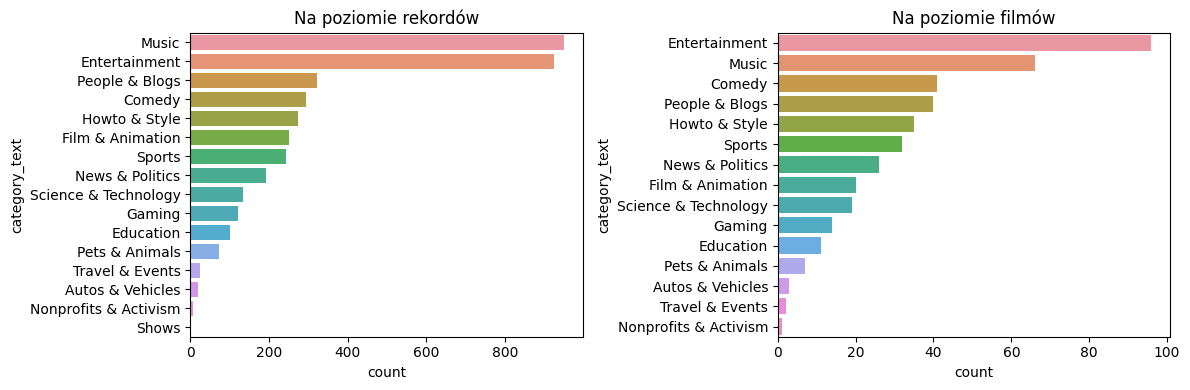

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=100)

sns.countplot(data=videos_df_merged, y="category_text", order=videos_df_merged["category_text"].value_counts().index, ax=ax[0])
ax[0].set(title='Na poziomie rekord√≥w')

videos_deduplicate_df = videos_df_merged.drop_duplicates(subset='video_id')
sns.countplot(data=videos_deduplicate_df, y="category_text", order=videos_deduplicate_df["category_text"].value_counts().index, ax=ax[1])
ax[1].set(title='Na poziomie film√≥w')

fig.tight_layout()

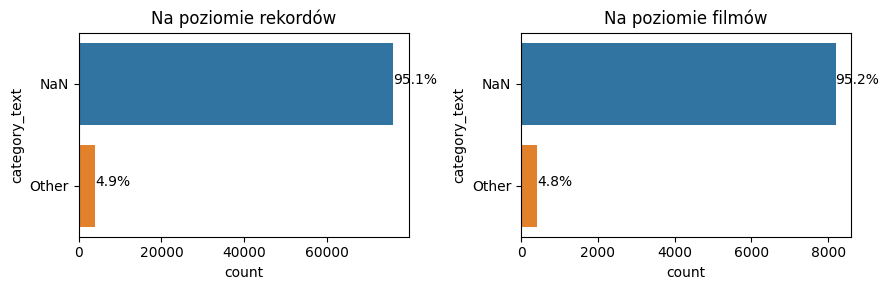

In [20]:
videos_df_merged_temp = videos_df_merged.fillna('NaN')
videos_df_merged_temp.loc[videos_df_merged_temp["category_text"] != 'NaN', "category_text"] = 'Other'

videos_df_merged_deduplicated_temp = videos_df_merged_temp.drop_duplicates(subset='video_id')

fig, ax = plt.subplots(1, 2, figsize=(9, 3), dpi=100)
sns.countplot(data=videos_df_merged_temp, y="category_text", order = videos_df_merged_temp["category_text"].value_counts().index, ax=ax[0])
ax[0].set(title='Na poziomie rekord√≥w')
total = len(videos_df_merged_temp['category_text'])
for p in ax[0].patches:
    percentage = '{:.1f}%'.format(100 * p.get_width()/total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height()/2
    ax[0].annotate(percentage, (x, y))

sns.countplot(data=videos_df_merged_deduplicated_temp, y="category_text", order = videos_df_merged_deduplicated_temp["category_text"].value_counts().index, ax=ax[1])
ax[1].set(title='Na poziomie film√≥w')
total = len(videos_df_merged_deduplicated_temp['category_text'])
for p in ax[1].patches:
    percentage = '{:.1f}%'.format(100 * p.get_width()/total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height()/2
    ax[1].annotate(percentage, (x, y))

fig.tight_layout()

### Naprawa kategori

W danych wystƒôpujƒÖ rekordy, kt√≥re dla tego samego ID filmu majƒÖ informacje o kategori w jednym z rekord√≥w, a w innych nie. Dlatego mo≈ºna ≈Çatwo wype≈Çniƒá brakujƒÖce rekordy.

In [21]:
video_category_df = videos_df.groupby('video_id').category_id.max()

print("Stosunek brakujƒÖcych kategori do wszystkich")
np.around(video_category_df.isna().sum() / video_category_df.isna().count(), 5)

Stosunek brakujƒÖcych kategori do wszystkich


0.67023

In [22]:
videos_df = videos_df.drop('category_id', axis=1).join(video_category_df, on='video_id')
videos_df.head()

video_id trending_date  \
0  2kyS6SvSYSE    2017-11-14   
1  1ZAPwfrtAFY    2017-11-14   
2  5qpjK5DgCt4    2017-11-14   
3  puqaWrEC7tY    2017-11-14   
4  d380meD0W0M    2017-11-14   

                                               title          channel_title  \
0                 WE WANT TO TALK ABOUT OUR MARRIAGE           CaseyNeistat   
1  The Trump Presidency: Last Week Tonight with J...        LastWeekTonight   
2  Racist Superman | Rudy Mancuso, King Bach & Le...           Rudy Mancuso   
3                   Nickelback Lyrics: Real or Fake?  Good Mythical Morning   
4                           I Dare You: GOING BALD!?               nigahiga   

               publish_time  \
0 2017-11-13 17:13:01+00:00   
1 2017-11-13 07:30:00+00:00   
2 2017-11-12 19:05:24+00:00   
3 2017-11-13 11:00:04+00:00   
4 2017-11-12 18:01:41+00:00   

                                                tags    views   likes  \
0                                    SHANtell martin   748374   57527   
1  last week tonight trump presidency|"last week ...  2418783   97185   
2  racist superman|"rudy"|"mancuso"|"king"|"bach"...  3191434  146033   
3  rhett and link|"gmm"|"good mythical morning"|"...   343168   10172   
4  ryan|"higa"|"higatv"|"nigahiga"|"i dare you"|"...  2095731  132235   

   dislikes  comment_count                                  thumbnail_link  \
0      2966          15954  https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg   
1      6146          12703  https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg   
2      5339           8181  https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg   
3       666           2146  https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg   
4      1989          17518  https://i.ytimg.com/vi/d380meD0W0M/default.jpg   

   comments_disabled  ratings_disabled  video_error_or_removed  \
0              False             False                   False   
1              False             False                   False   
2              False             False                   False   
3              False             False                   False   
4              False             False                   False   

                                         description origin  category_id  
0  SHANTELL'S CHANNEL - https://www.youtube.com/s...     US          NaN  
1  One year after the presidential election, John...     US          NaN  
2  WATCH MY PREVIOUS VIDEO ‚ñ∂  SUBSCRIBE ‚ñ∫ https:/...     US         23.0  
3  Today we find out if Link is a Nickelback amat...     US          NaN  
4  I know it's been a while since we did this sho...     US          NaN

Naprawione kategorie

In [23]:
videos_df_merged = videos_df.merge(df_us_categories, left_on='category_id', right_on='id', how='left')
videos_df_merged.drop(columns=['id'], inplace=True)
videos_df_merged.iloc[[0,1,2,-3,-2,-1]]

video_id trending_date  \
0      2kyS6SvSYSE    2017-11-14   
1      1ZAPwfrtAFY    2017-11-14   
2      5qpjK5DgCt4    2017-11-14   
79862  Il-an3K9pjg    2018-06-14   
79863  eDSgs6syrgg    2018-06-14   
79864  4YFo4bdMO8Q    2018-06-14   

                                                   title  \
0                     WE WANT TO TALK ABOUT OUR MARRIAGE   
1      The Trump Presidency: Last Week Tonight with J...   
2      Racist Superman | Rudy Mancuso, King Bach & Le...   
79862                 Anne-Marie - 2002 [Official Video]   
79863  Eleni Foureira - Fuego - Cyprus - LIVE - First...   
79864  KYLE - Ikuyo feat.  2 Chainz & Sophia Black [A...   

                 channel_title              publish_time  \
0                 CaseyNeistat 2017-11-13 17:13:01+00:00   
1              LastWeekTonight 2017-11-13 07:30:00+00:00   
2                 Rudy Mancuso 2017-11-12 19:05:24+00:00   
79862               Anne-Marie 2018-05-08 11:05:08+00:00   
79863  Eurovision Song Contest 2018-05-08 20:32:32+00:00   
79864           SuperDuperKyle 2018-05-11 04:06:35+00:00   

                                                    tags     views   likes  \
0                                        SHANtell martin    748374   57527   
1      last week tonight trump presidency|"last week ...   2418783   97185   
2      racist superman|"rudy"|"mancuso"|"king"|"bach"...   3191434  146033   
79862  anne|"marie"|"anne-marie"|"2002"|"two thousand...  29641412  394830   
79863  Eurovision Song Contest|"2018"|"Lisbon"|"Cypru...  14317515  151870   
79864  Kyle|"SuperDuperKyle"|"Ikuyo"|"2 Chainz"|"Soph...    607552   18271   

       dislikes  comment_count  \
0          2966          15954   
1          6146          12703   
2          5339           8181   
79862      8892          19988   
79863     45875          26766   
79864       274           1423   

                                       thumbnail_link  comments_disabled  \
0      https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg              False   
1      https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg              False   
2      https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg              False   
79862  https://i.ytimg.com/vi/Il-an3K9pjg/default.jpg              False   
79863  https://i.ytimg.com/vi/-DRsfNObKIQ/default.jpg              False   
79864  https://i.ytimg.com/vi/4YFo4bdMO8Q/default.jpg              False   

       ratings_disabled  video_error_or_removed  \
0                 False                   False   
1                 False                   False   
2                 False                   False   
79862             False                   False   
79863             False                   False   
79864             False                   False   

                                             description origin  category_id  \
0      SHANTELL'S CHANNEL - https://www.youtube.com/s...     US          NaN   
1      One year after the presidential election, John...     US          NaN   
2      WATCH MY PREVIOUS VIDEO ‚ñ∂  SUBSCRIBE ‚ñ∫ https:/...     US         23.0   
79862  Get 2002 by Anne-Marie HERE ‚ñ∂ http://ad.gt/200...     GB         10.0   
79863  Eleni Foureira represented Cyprus at the first...     GB         24.0   
79864  Debut album 'Light of Mine' out now: http://ky...     GB          NaN   

       category_text  
0                NaN  
1                NaN  
2             Comedy  
79862          Music  
79863  Entertainment  
79864            NaN

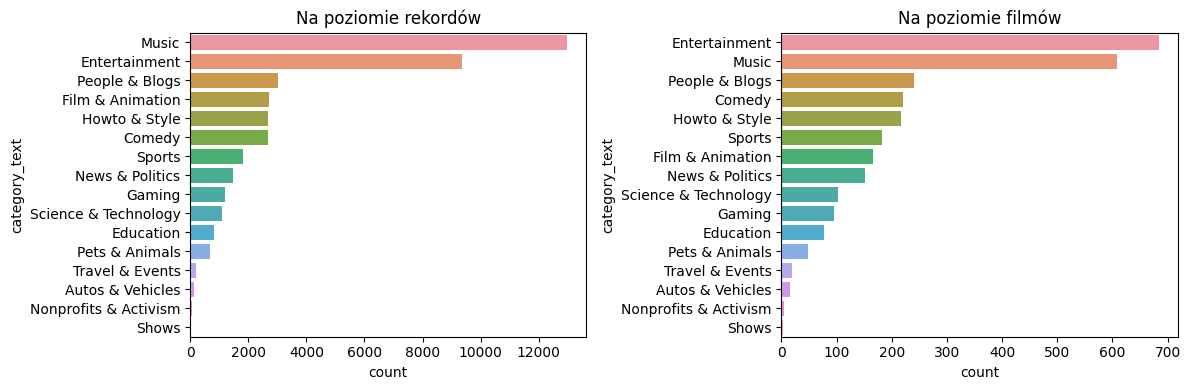

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=100)

sns.countplot(data=videos_df_merged, y="category_text", order=videos_df_merged["category_text"].value_counts().index, ax=ax[0])
ax[0].set(title='Na poziomie rekord√≥w')

videos_deduplicate_df = videos_df_merged.drop_duplicates(subset='video_id')
sns.countplot(data=videos_deduplicate_df, y="category_text", order=videos_deduplicate_df["category_text"].value_counts().index, ax=ax[1])
ax[1].set(title='Na poziomie film√≥w')

fig.tight_layout()

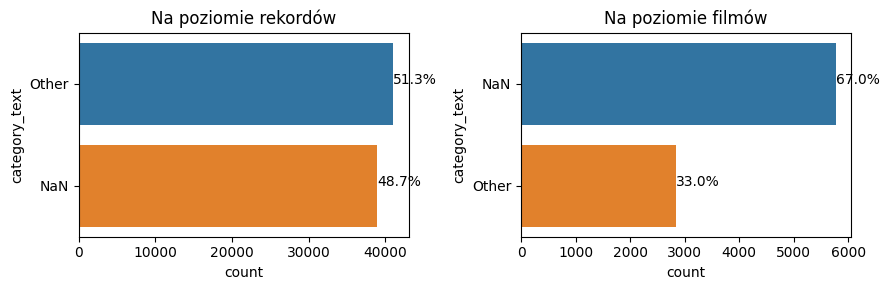

In [25]:
videos_df_merged_temp = videos_df_merged.fillna('NaN')
videos_df_merged_temp.loc[videos_df_merged_temp["category_text"] != 'NaN', "category_text"] = 'Other'

videos_df_merged_deduplicated_temp = videos_df_merged_temp.drop_duplicates(subset='video_id')

fig, ax = plt.subplots(1, 2, figsize=(9, 3), dpi=100)
sns.countplot(data=videos_df_merged_temp, y="category_text", order = videos_df_merged_temp["category_text"].value_counts().index, ax=ax[0])
ax[0].set(title='Na poziomie rekord√≥w')
total = len(videos_df_merged_temp['category_text'])
for p in ax[0].patches:
    percentage = '{:.1f}%'.format(100 * p.get_width()/total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height()/2
    ax[0].annotate(percentage, (x, y))

sns.countplot(data=videos_df_merged_deduplicated_temp, y="category_text", order = videos_df_merged_deduplicated_temp["category_text"].value_counts().index, ax=ax[1])
ax[1].set(title='Na poziomie film√≥w')
total = len(videos_df_merged_deduplicated_temp['category_text'])
for p in ax[1].patches:
    percentage = '{:.1f}%'.format(100 * p.get_width()/total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height()/2
    ax[1].annotate(percentage, (x, y))

fig.tight_layout()

Top 5 najbardziej popularnych kana≈Ç√≥w

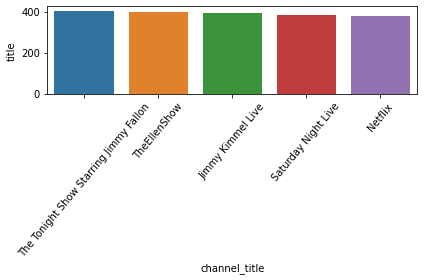

In [26]:
df = videos_df_merged
df_trending_ch = df.groupby(by=['channel_title'], as_index=False).count().sort_values(by='title', ascending=False).head()
sns.barplot(
    x = 'channel_title',
    y = 'title',
    data = df_trending_ch)
plt.xticks(rotation=50)
plt.tight_layout()

Najczƒô≈õciej wystƒôpujƒÖce s≈Çowa w tagach film√≥w - po oczyszczeniu tag√≥w

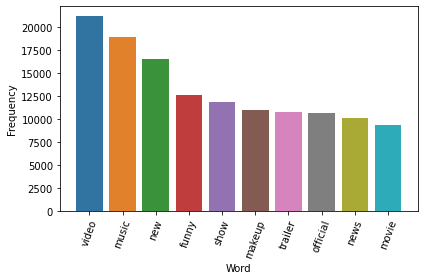

In [27]:
stopwords_list = list(stopwords.words('english'))   

df = videos_df_merged

for col in ['tags']:
    wordtokens = word_tokenize(re.sub('[^A-Za-z]+', ' ', df[col].str.lower().str.cat(sep=' ')))

    # Remove stopwords_list, numbers and short words
    w_temp = []
    for word in wordtokens:
        if (word not in stopwords_list) and (len(word) > 2) and not (word.isnumeric()):
            w_temp.append(word)

    word_dist = nltk.FreqDist(w_temp)
    df_temp = pd.DataFrame(word_dist.most_common(100), columns=['Word', 'Frequency'])
    sns.barplot(x="Word", y="Frequency", data=df_temp.head(10))
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.plot()

# In≈ºynieria cech bazujƒÖcych na znaczniku czasowym

In [28]:
timestam_features = ['publish_time', 'trending_date']

def handle_dates(df, cols):
    for col in cols:
        df[col+'_day'] = df[col].dt.day
        df[col+'_month'] = df[col].dt.month
        df[col+'_year'] = df[col].dt.year
        df[col+'_weekday'] = df[col].dt.dayofweek
        df[col+'_quarter'] = df[col].dt.quarter
        if col == 'publish_time':
            df[col+'_hour'] = df[col].dt.hour
            df[col+'_minute'] = df[col].dt.minute
            df[col+'_second'] = df[col].dt.second
    return df

videos_df_merged = handle_dates(videos_df_merged, timestam_features)
videos_df_merged.head(3)

video_id trending_date  \
0  2kyS6SvSYSE    2017-11-14   
1  1ZAPwfrtAFY    2017-11-14   
2  5qpjK5DgCt4    2017-11-14   

                                               title    channel_title  \
0                 WE WANT TO TALK ABOUT OUR MARRIAGE     CaseyNeistat   
1  The Trump Presidency: Last Week Tonight with J...  LastWeekTonight   
2  Racist Superman | Rudy Mancuso, King Bach & Le...     Rudy Mancuso   

               publish_time  \
0 2017-11-13 17:13:01+00:00   
1 2017-11-13 07:30:00+00:00   
2 2017-11-12 19:05:24+00:00   

                                                tags    views   likes  \
0                                    SHANtell martin   748374   57527   
1  last week tonight trump presidency|"last week ...  2418783   97185   
2  racist superman|"rudy"|"mancuso"|"king"|"bach"...  3191434  146033   

   dislikes  comment_count  ... publish_time_weekday  publish_time_quarter  \
0      2966          15954  ...                    0                     4   
1      6146          12703  ...                    0                     4   
2      5339           8181  ...                    6                     4   

   publish_time_hour  publish_time_minute publish_time_second  \
0                 17                   13                   1   
1                  7                   30                   0   
2                 19                    5                  24   

  trending_date_day  trending_date_month trending_date_year  \
0                14                   11               2017   
1                14                   11               2017   
2                14                   11               2017   

   trending_date_weekday  trending_date_quarter  
0                      1                      4  
1                      1                      4  
2                      1                      4  

[3 rows x 31 columns]

#### D≈Çugo≈õƒá (w dniach) bycia trendy

In [72]:
videos_df = videos_df_merged
trending_span_df = videos_df.groupby('video_id').trending_date.agg([np.max, np.min]).rename({'amin': 'trending_date_start', 'amax': 'trending_date_end'}, axis=1)

trending_span_df.head()

trending_date_end trending_date_start
video_id                                         
--uXQQ0h-yQ        2018-01-02          2017-12-25
-0CMnp02rNY        2018-06-11          2018-06-06
-0NYY8cqdiQ        2018-02-01          2018-02-01
-1Hm41N0dUs        2018-05-01          2018-04-29
-1yT-K3c6YI        2017-12-02          2017-11-29

[Text(0.5, 1.0, 'Okres popularno≈õci film√≥w w dniach')]

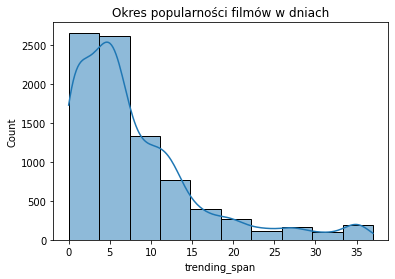

In [73]:
videos_df = videos_df.join(trending_span_df, on='video_id')
videos_df['trending_span'] = videos_df.trending_date_end - videos_df.trending_date_start

g = sns.histplot(videos_df.drop_duplicates(subset='video_id').trending_span.dt.days, kde=True, bins=10)
g.set(title='Okres popularno≈õci film√≥w w dniach')

#### Czas od uploadu do bycia popularnym

/home/hylomorph/Study/ped/yt_trending_videos/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning:

invalid value encountered in log10



<AxesSubplot:xlabel='publish_to_trending_span_in_hours', ylabel='Count'>

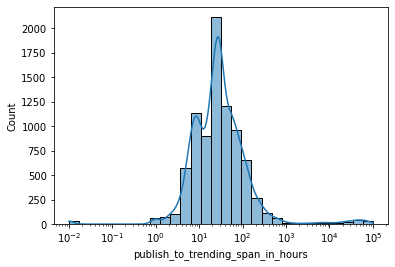

In [128]:
videos_df['publish_to_trending_span'] = videos_df.trending_date_start.dt.tz_localize(tz='UTC') - videos_df.publish_time
componets_df = videos_df.publish_to_trending_span.dt.components

videos_df['publish_to_trending_span_in_hours'] = componets_df.days * 24 + componets_df.hours
sns.histplot(videos_df.drop_duplicates(subset=['video_id']).publish_to_trending_span_in_hours + 0.01, bins=30, kde=True, log_scale=True)

Ostateczna i poczƒÖtkowa liczba zebranych ≈Çapek w g√≥rƒô, d√≥≈Ç, komentarzy oraz wy≈õwietle≈Ñ

In [31]:
def min_max(df, column):
    result = df.sort_values('trending_date').groupby('video_id')[column].agg(['first', 'last']).rename(lambda n: f'{column}_{n}', axis=1)
    result[f'{column}_diff'] = result[f'{column}_last'] - result[f'{column}_first']
    return result

min_max_df = min_max(videos_df, 'likes').join(min_max(videos_df, 'dislikes')).\
    join(min_max(videos_df, 'views')).\
    join(min_max(videos_df, 'comment_count'))

def like_dislikes_ratios(df, col):
    df[f'votes_{col}'] = df[f'likes_{col}'] + df[f'dislikes_{col}']
    df[f'likes_ratio_{col}'] = df[f'likes_{col}'] / df[f'votes_{col}']
    df[f'dislike_ratio_{col}'] = df[f'dislikes_{col}'] / df[f'votes_{col}']


like_dislikes_ratios(min_max_df, 'last')
like_dislikes_ratios(min_max_df, 'first')
min_max_df.head()

likes_first  likes_last  likes_diff  dislikes_first  \
video_id                                                           
--uXQQ0h-yQ          216         253          37               3   
-0CMnp02rNY         6531        9773        3242             172   
-0NYY8cqdiQ         4429        4429           0              54   
-1Hm41N0dUs        32752       41248        8496             393   
-1yT-K3c6YI         5214        7734        2520             108   

             dislikes_last  dislikes_diff  views_first  views_last  \
video_id                                                             
--uXQQ0h-yQ              3              0        24723       28725   
-0CMnp02rNY            332            160       475965      800359   
-0NYY8cqdiQ             54              0       563746      563746   
-1Hm41N0dUs            580            187      1566807     2058516   
-1yT-K3c6YI            212            104       129360      231341   

             views_diff  comment_count_first  comment_count_last  \
video_id                                                           
--uXQQ0h-yQ        4002                   10                  12   
-0CMnp02rNY      324394                  271                 423   
-0NYY8cqdiQ           0                   94                  94   
-1Hm41N0dUs      491709                 1490                1484   
-1yT-K3c6YI      101981                  516                 846   

             comment_count_diff  votes_last  likes_ratio_last  \
video_id                                                        
--uXQQ0h-yQ                   2         256          0.988281   
-0CMnp02rNY                 152       10105          0.967145   
-0NYY8cqdiQ                   0        4483          0.987954   
-1Hm41N0dUs                  -6       41828          0.986134   
-1yT-K3c6YI                 330        7946          0.973320   

             dislike_ratio_last  votes_first  likes_ratio_first  \
video_id                                                          
--uXQQ0h-yQ            0.011719          219           0.986301   
-0CMnp02rNY            0.032855         6703           0.974340   
-0NYY8cqdiQ            0.012046         4483           0.987954   
-1Hm41N0dUs            0.013866        33145           0.988143   
-1yT-K3c6YI            0.026680         5322           0.979707   

             dislike_ratio_first  
video_id                          
--uXQQ0h-yQ             0.013699  
-0CMnp02rNY             0.025660  
-0NYY8cqdiQ             0.012046  
-1Hm41N0dUs             0.011857  
-1yT-K3c6YI             0.020293

In [32]:
videos_df = videos_df.join(min_max_df, on='video_id')
videos_df.head()

video_id trending_date  \
0  2kyS6SvSYSE    2017-11-14   
1  1ZAPwfrtAFY    2017-11-14   
2  5qpjK5DgCt4    2017-11-14   
3  puqaWrEC7tY    2017-11-14   
4  d380meD0W0M    2017-11-14   

                                               title          channel_title  \
0                 WE WANT TO TALK ABOUT OUR MARRIAGE           CaseyNeistat   
1  The Trump Presidency: Last Week Tonight with J...        LastWeekTonight   
2  Racist Superman | Rudy Mancuso, King Bach & Le...           Rudy Mancuso   
3                   Nickelback Lyrics: Real or Fake?  Good Mythical Morning   
4                           I Dare You: GOING BALD!?               nigahiga   

               publish_time  \
0 2017-11-13 17:13:01+00:00   
1 2017-11-13 07:30:00+00:00   
2 2017-11-12 19:05:24+00:00   
3 2017-11-13 11:00:04+00:00   
4 2017-11-12 18:01:41+00:00   

                                                tags    views   likes  \
0                                    SHANtell martin   748374   57527   
1  last week tonight trump presidency|"last week ...  2418783   97185   
2  racist superman|"rudy"|"mancuso"|"king"|"bach"...  3191434  146033   
3  rhett and link|"gmm"|"good mythical morning"|"...   343168   10172   
4  ryan|"higa"|"higatv"|"nigahiga"|"i dare you"|"...  2095731  132235   

   dislikes  comment_count  ... views_diff  comment_count_first  \
0      2966          15954  ...    1816529                15954   
1      6146          12703  ...    3690619                12703   
2      5339           8181  ...    2124037                 8181   
3       666           2146  ...     570100                 2146   
4      1989          17518  ...     723387                17518   

   comment_count_last  comment_count_diff votes_last likes_ratio_last  \
0               22149                6195     104293         0.923562   
1               19820                7117     162758         0.929294   
2                9990                1809     194581         0.962597   
3                2988                 842      18115         0.923489   
4               20573                3055     155811         0.984494   

   dislike_ratio_last votes_first  likes_ratio_first  dislike_ratio_first  
0            0.076438       60493           0.950970             0.049030  
1            0.070706      103331           0.940521             0.059479  
2            0.037403      151372           0.964729             0.035271  
3            0.076511       10838           0.938550             0.061450  
4            0.015506      134224           0.985181             0.014819  

[5 rows x 52 columns]

[Text(0.5, 1.0, 'Liczba polubie≈Ñ na poczƒÖtku popularno≈õci')]

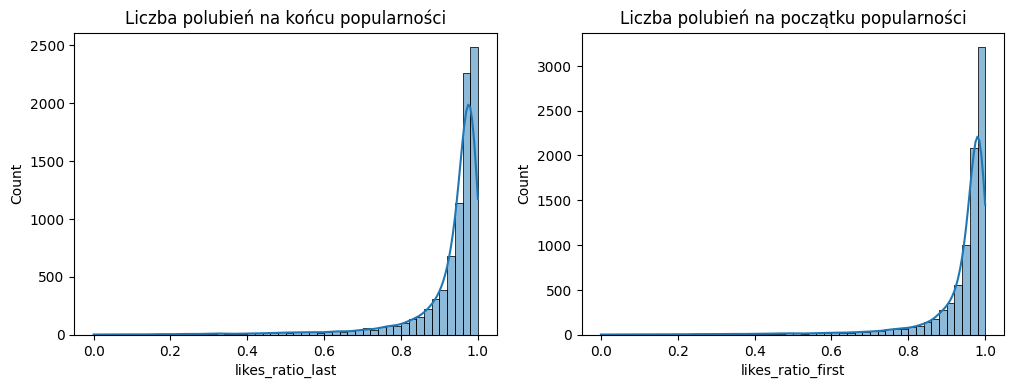

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=100)
sns.histplot(data=min_max_df.likes_ratio_last, kde=True, bins=50, ax=ax[0])
ax[0].set(title='Liczba polubie≈Ñ na ko≈Ñcu popularno≈õci')
sns.histplot(data=min_max_df.likes_ratio_first, kde=True, bins=50, ax=ax[1])
ax[1].set(title='Liczba polubie≈Ñ na poczƒÖtku popularno≈õci')

# In≈ºynieria cech tekstowych

In [34]:
text_features = ['title', 'description', 'channel_title']

### Proste cechy
Liczba znak√≥w zapytania, liczba wykrzyknik√≥w, liczba liter i cyfr, liczba link√≥w, liczba dolar√≥w, liczba hashtag√≥w.

Dostƒôpne znaki:


In [35]:
import string
' '.join(list(string.punctuation))

'! " # $ % & \' ( ) * + , - . / : ; < = > ? @ [ \\ ] ^ _ ` { | } ~'

Symbole czƒôsto wykorzystywane do wzbudzenia zainteresowania:

In [36]:
attention_symbols = '!?$#'

#### Liczba znak√≥w specjalnych

In [37]:
def plot_text_features_distributions(df, features=None, log=False):
    if features is None:
        features = text_features
    
    fig, ax = plt.subplots(2,2, figsize=(10,6), dpi=100)
    g = sns.boxenplot(data=df.melt(), x='variable', y='value', ax=ax[0,0])
    g = sns.histplot(data=df[features[0]] + (0.000000001 if log else 0), ax=ax[0,1], kde=True, bins=50, log_scale=log)
    g = sns.histplot(data=df[features[1]] + (0.000000001 if log else 0), ax=ax[1,0], kde=True, bins=50, log_scale=log)
    g = sns.histplot(data=df[features[2]] + (0.000000001 if log else 0), ax=ax[1,1], kde=True, bins=50, log_scale=log)

    fig.tight_layout()
    plt.show()

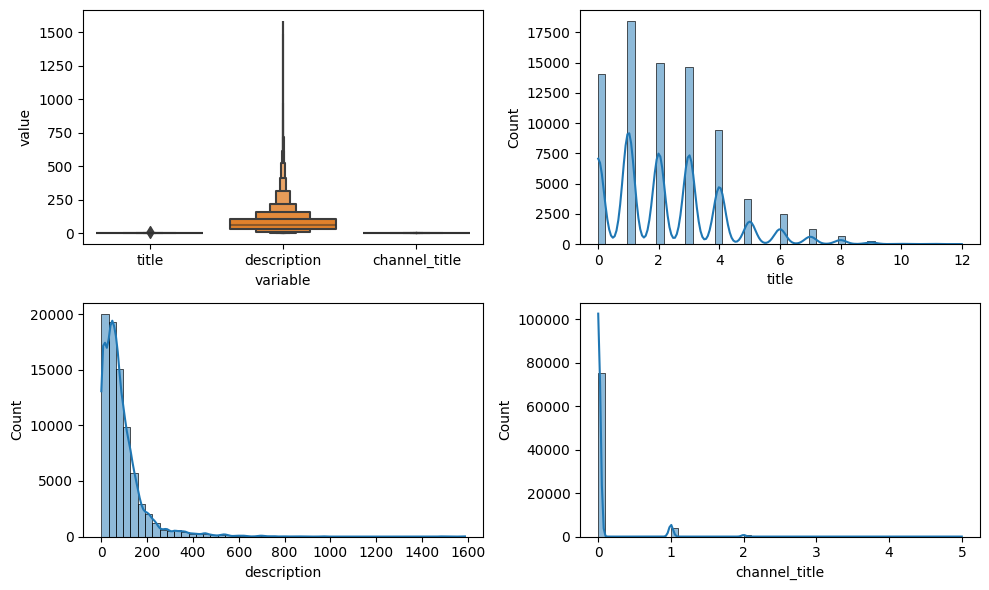

In [38]:
def punctutation_count(text):
    return len([c for c in str(text) if c in string.punctuation])

punctutation_count_df = videos_df[text_features].applymap(punctutation_count)
videos_df[[n+'_punctuation_count' for n in text_features]] = punctutation_count_df
plot_text_features_distributions(punctutation_count_df)

#### Liczba znak√≥w atencji

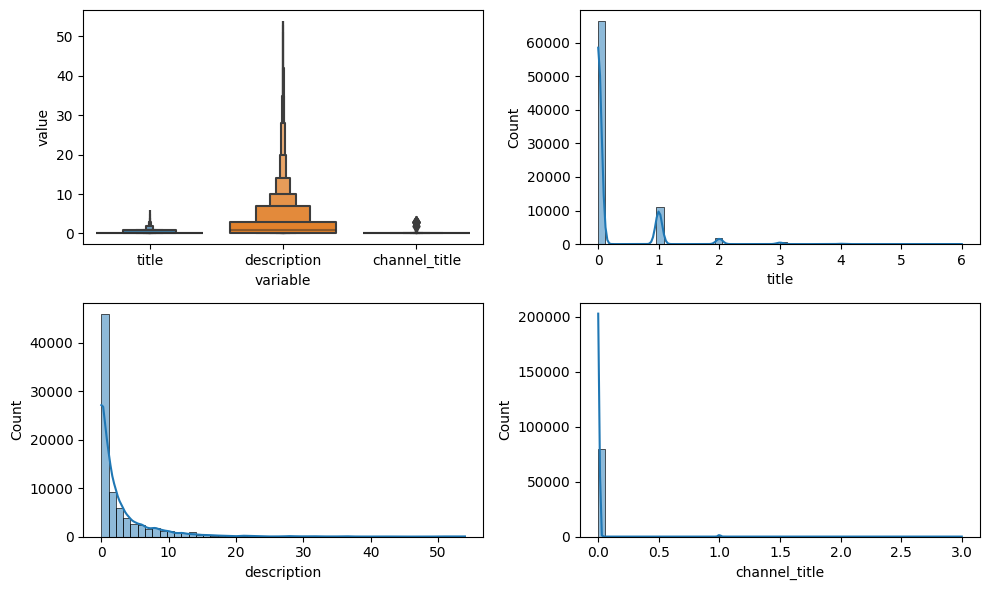

In [39]:
def attention_count(text):
    return len([c for c in str(text) if c in attention_symbols])

attention_count_df = videos_df[text_features].applymap(attention_count)
videos_df[[n+'_attention_count' for n in text_features]] = attention_count_df
plot_text_features_distributions(attention_count_df)

#### D≈Çugo≈õƒá tekstu

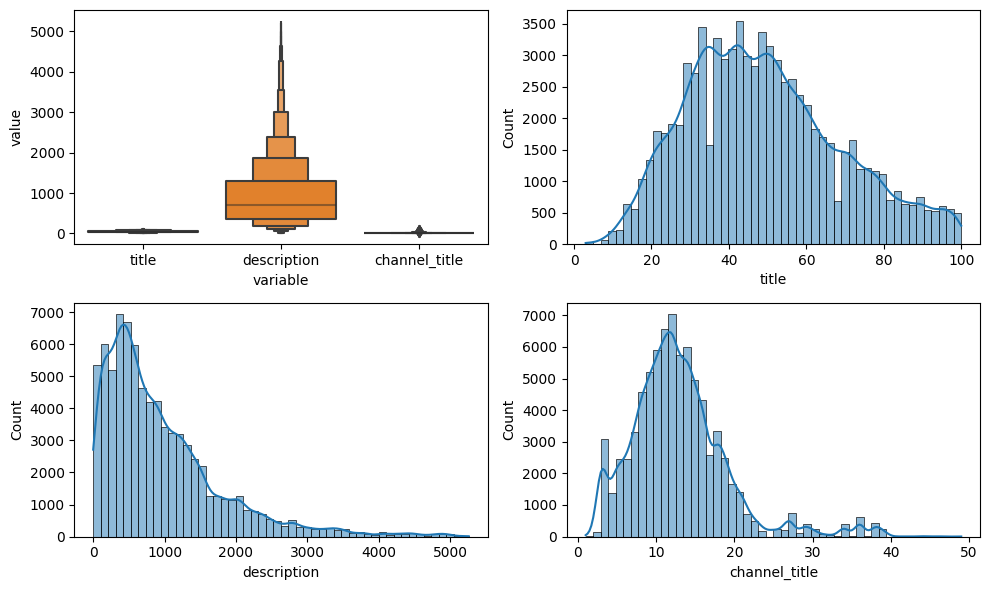

In [40]:
def text_len(text):
    return len(str(text))

text_len_df = videos_df[text_features].applymap(text_len)
videos_df[[n+'_len' for n in text_features]] = text_len_df
plot_text_features_distributions(text_len_df)

#### D≈Çugo≈õƒá tekstu

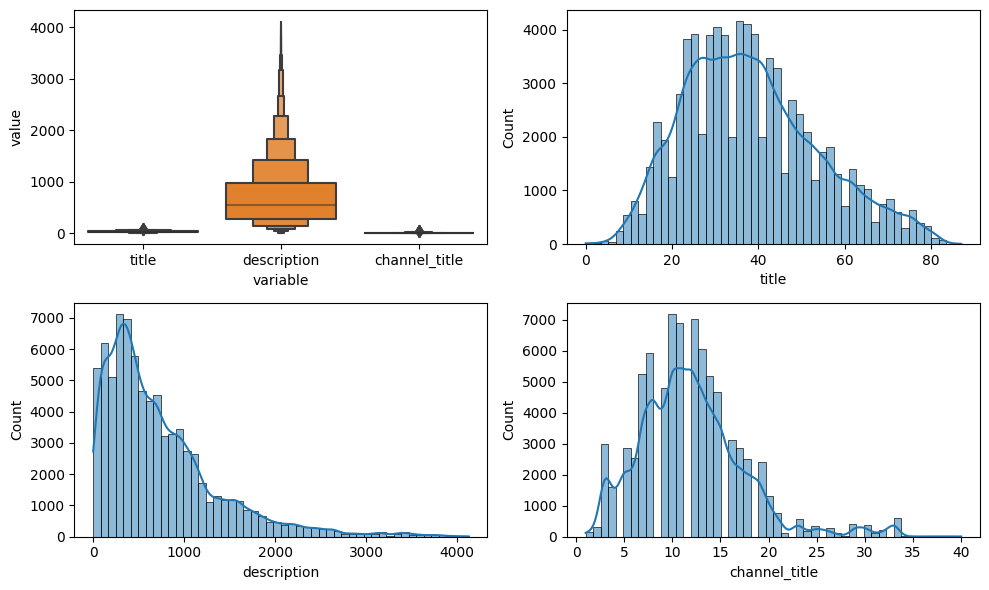

In [41]:
def letter_count(text):
    return len(list(filter(str.isalpha, str(text))))

letter_count_df = videos_df[text_features].applymap(letter_count)
videos_df[[n+'_letter_count' for n in text_features]] = letter_count_df
plot_text_features_distributions(letter_count_df)

#### Stosunek liter do wszystkich znak√≥w - poziom informatywno≈õci

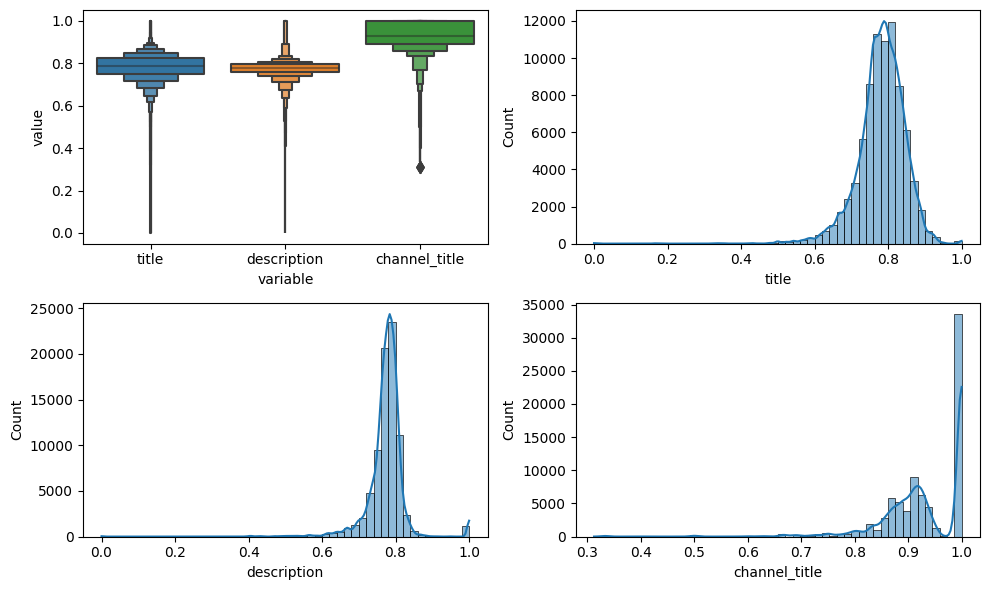

In [42]:
def information_ratio(df):
    for name in text_features:
        df[name+'_information_ratio'] = (df[name+'_letter_count'] / df[name+'_len']).fillna(0)
    return df

information_ratio_names = [n+'_information_ratio' for n in text_features]
videos_df = information_ratio(videos_df)
plot_text_features_distributions(videos_df[information_ratio_names].rename(lambda n: n.split('_information')[0], axis=1))

Opisy o ma≈Çej najmniejszej zawarto≈õci informacyjnej. Widaƒá ≈ºe wystƒôpujƒÖ filmy, kt√≥re posiadajƒÖ jedynie kropki w opisie filmy lub w og√≥le nie majƒÖ opisu.

In [43]:
videos_df[['title', 'description', 'description_information_ratio']].sort_values('description_information_ratio').head(10)

title description  \
12740  The Cranberries - Dreams (Music Video HQ)               
11102       notting-hill-movie-clip-last-brownie               
53859        Regarding the rumors about me today           .   
53626        Regarding the rumors about me today           .   
54939        Regarding the rumors about me today           .   
52553        Regarding the rumors about me today           .   
53396        Regarding the rumors about me today           .   
44435              Roberto Carlos vs France 1997               
54502        Regarding the rumors about me today           .   
11328       notting-hill-movie-clip-last-brownie               

       description_information_ratio  
12740                            0.0  
11102                            0.0  
53859                            0.0  
53626                            0.0  
54939                            0.0  
52553                            0.0  
53396                            0.0  
44435                            0.0  
54502                            0.0  
11328                            0.0

Opisy o ma≈Çej najmniejszej zawarto≈õci informacyjnej pomiƒôdzy 0.1, a 0.2


#### Stosunek znak√≥w atencji do wszystkich liter

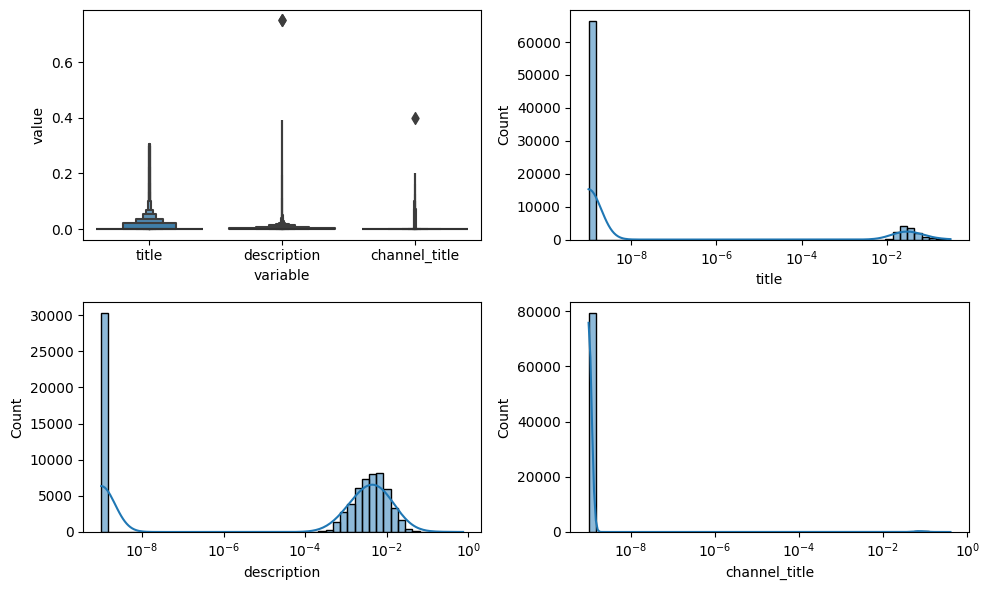

In [44]:
def attention_ratio(df):
    for name in text_features:
        df[name+'_attention_ratio'] = (df[name+'_attention_count'] / df[name+'_letter_count']).fillna(0)
    return df

attention_ratio_names = [n+'_attention_ratio' for n in text_features]
videos_df = attention_ratio(videos_df)
plot_text_features_distributions(videos_df[attention_ratio_names].rename(lambda n: n.split('_attention')[0], axis=1), log=True)

Mo≈ºna zobaczyƒá, ≈ºe wystƒôpujƒÖ filmy o bardzo du≈ºym wsp√≥≈Çczyniku atencji w opisie, zawierajƒÖ ogromnƒÖ liczbƒô wykrzyknik√≥w lub hashtag√≥w

In [45]:
videos_df.drop_duplicates(subset=['video_id'])[['title', 'description', 'description_attention_ratio']]. \
    sort_values('description_attention_ratio', ascending=False)

title  \
52098        Omae wa mo shinderu | The Last Jedi edition   
44155        Jesse Lingard's INSANE solo Goal vs Watford   
12218  Saints vs Vikings 2018 (Minnesota Vikings  Mir...   
49946  [SPECIAL VIDEO] NU'EST W(Îâ¥Ïù¥Ïä§Ìä∏W) & SEVENTEEN(ÏÑ∏Î∏ê...   
45170                  Zion.T ‚Äì 'Îàà(SNOW) (feat.Ïù¥Î¨∏ÏÑ∏)' M/V   
...                                                  ...   
18586  Watch Rosenstein‚Äôs full announcement of the in...   
18588  Meet Nathan Chen, the Figure Skater Who Brough...   
18593       Demi Lovato - Tell Me You Love Me (Acoustic)   
18595  Mic'd up: Listen to Mikaela Shiffrin's gold me...   
20183  Kylie Minogue - Dancing (Live Ant & Dec's Satu...   

                                             description  \
52098                                            Nani!!?   
44155  Jesse Lingard 4-2 !!!!!!!!!!!\n\nINSANE solo Goal   
12218                                  SKOL! SKOL! SKOL!   
49946                          #ÌîåÎ†àÎîîÏä§ #Îâ¥Ïù¥Ïä§Ìä∏W #ÏÑ∏Î∏êÌã¥ #HEAVEN   
45170  #ZIONT #ÏûêÏù¥Ïñ∏Ìã∞ #with #LEEMOONSAE #Ïù¥Î¨∏ÏÑ∏ #AHNJAEHON...   
...                                                  ...   
18586  Deputy Attorney General Rod J. Rosenstein on F...   
18588  Nathan Chen is 18 and the United States' best ...   
18593  Demi Lovato Tell Me You Love Me DELUXE: https:...   
18595  A nearly unfiltered and behind-the-scenes look...   
20183                                                NaN   

       description_attention_ratio  
52098                     0.750000  
44155                     0.392857  
12218                     0.250000  
49946                     0.222222  
45170                     0.194030  
...                            ...  
18586                     0.000000  
18588                     0.000000  
18593                     0.000000  
18595                     0.000000  
20183                     0.000000  

[8606 rows x 3 columns]

Mo≈ºna zobaczyƒá, ≈ºe wystƒôpujƒÖ filmy o bardzo du≈ºym wsp√≥≈Çczyniku atencji w tytule, zawierajƒÖ ogromnƒÖ liczbƒô wykrzyknik√≥w lub hashtag√≥w. Co ciekawe filmy kt√≥re dosta≈Çy siƒô na kartƒô Trendy, nie posiadajƒÖ gigantycznej liczby wykrzyknik√≥w lub znak√≥w zapytania w tytule. Mo≈ºe to oznaczaƒá, ≈ºe tworzenie "clickbaitowych" wymaga pewnego przemy≈õlenia, a nie dodawania du≈ºej liczby wykrzyknik√≥w.

In [46]:
videos_df.drop_duplicates(subset=['video_id'])[['title', 'title_attention_ratio']].sort_values('title_attention_ratio', ascending=False)

title  \
75578                             #Laurel? #Yanny? Or...   
15991                             üò± $1,145 iPhone Case!!   
19620                               WTF - $300 Toaster?!   
13565                               ÏÉùÌõÑ 60Ïùº Îêú ÏÉàÎÅºÍ∞Ä ÏÇ¨ÎùºÏ°åÎã§!!?   
38955                            $40 Gym Vs. $10,000 Gym   
...                                                  ...   
14242                          BTS Takes on L.A. | Vogue   
14237  Brad Makes Sous Vide Steak | Kitchen Basics | ...   
14236  Judge Aquilina Delivers Powerful Statement Bef...   
14235               People Try The New Diet Coke Flavors   
79836    17 FUN LIFE HACKS YOU WILL WANT TO TRY YOURSELF   

       title_attention_ratio  
75578               0.307692  
15991               0.300000  
19620               0.300000  
13565               0.272727  
38955               0.250000  
...                      ...  
14242               0.000000  
14237               0.000000  
14236               0.000000  
14235               0.000000  
79836               0.000000  

[8606 rows x 2 columns]

#### Liczenie s≈Ç√≥w

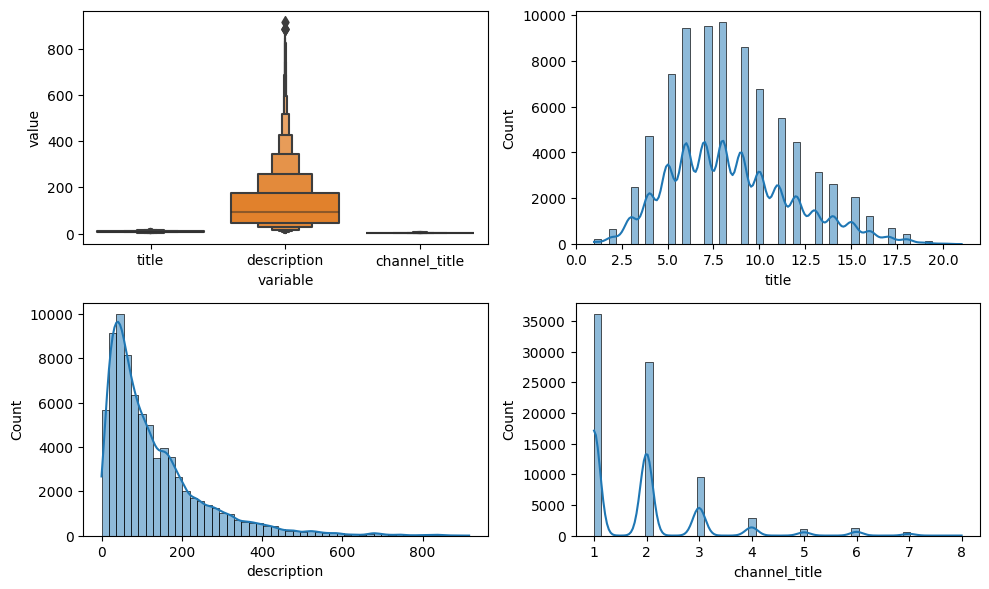

In [47]:
def word_count(df):
    for name in text_features:
        df[name+'_word_count'] = df[name].str.count(r"[\w\-_#\/\\\+\:$?]+")
    return df

word_count_names = [name+'_word_count' for name in text_features]
videos_df = word_count(videos_df)
plot_text_features_distributions(videos_df[word_count_names].rename(lambda n: n.split('_word')[0], axis=1))

#### Liczenie hiperlink√≥w w opisie

<AxesSubplot:xlabel='description_url_count', ylabel='Count'>

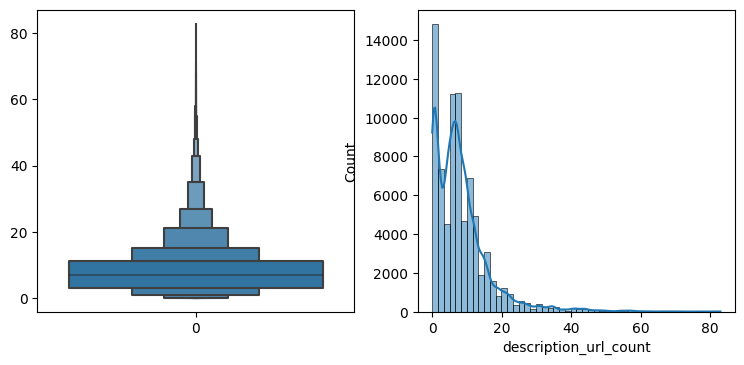

In [48]:
def url_count(df):
    df['description_url_count'] = df.description.str.count(r"(https?:\/\/)?(\w+\.\w+)[\?=\&\w_\-.\/.]*")
    return df

videos_df = url_count(videos_df)
fig, ax = plt.subplots(1, 2, figsize=(9,4), dpi=100)
sns.boxenplot(data=videos_df.description_url_count, ax=ax[0])
sns.histplot(data=videos_df.description_url_count, kde=True, bins=50, ax=ax[1])

#### Stosunek hiperlink√≥w do s≈Ç√≥w w opisie

<AxesSubplot:xlabel='description_url_ratio', ylabel='Count'>

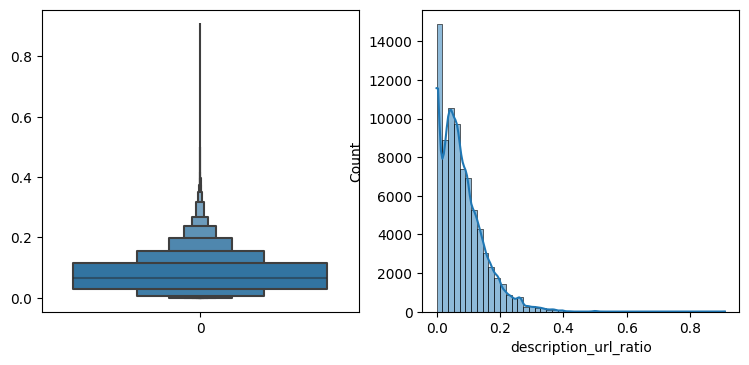

In [49]:
def url_ratio(df):
    df['description_url_ratio'] = (df['description_url_count'] / df['description_word_count']).fillna(0)
    return df

videos_df = url_ratio(videos_df)
fig, ax = plt.subplots(1, 2, figsize=(9,4), dpi=100)
sns.boxenplot(data=videos_df.description_url_ratio, ax=ax[0])
sns.histplot(data=videos_df.description_url_ratio, kde=True, bins=50, ax=ax[1])

In [50]:
videos_df.drop_duplicates(subset=['video_id'])[['title', 'description', 'description_url_ratio']].sort_values('description_url_ratio', ascending=False)

title  \
4935                    It's Here!!! CASEY NEISTAT MERCH   
14273                 China BANS Hip Hop From Television   
5490                               exixe clock in action   
69173                                YOU GROOVE YOU LOSE   
66892                                    GREENTEXT MEMES   
...                                                  ...   
7898   FLOYD MAYWEATHER KILLS UFC TALK; DENIES DANA W...   
7933            Jonghyun Lonely (Feat. ÌÉúÏó∞) - Piano Cover   
7984       Christian Bale: Division Is Not The Way To Go   
45170                  Zion.T ‚Äì 'Îàà(SNOW) (feat.Ïù¥Î¨∏ÏÑ∏)' M/V   
20183  Kylie Minogue - Dancing (Live Ant & Dec's Satu...   

                                             description  \
4935   https://shopcaseyneistat.com https://shopcasey...   
14273  http://time.com/5112061/china-hip-hop-ban-tatt...   
5490   https://github.com/dekuNukem/exixe https://git...   
69173  SUBMIT MEMES: https://www.reddit.com/r/Pewdiep...   
66892  SUBMIT MEMES: https://www.reddit.com/r/Pewdiep...   
...                                                  ...   
7898   That's not what I said....exactly what I said ...   
7933   Jonghyun is the best artist who loved music mo...   
7984   The actor says our culture will be richer when...   
45170  #ZIONT #ÏûêÏù¥Ïñ∏Ìã∞ #with #LEEMOONSAE #Ïù¥Î¨∏ÏÑ∏ #AHNJAEHON...   
20183                                                NaN   

       description_url_ratio  
4935                0.500000  
14273               0.500000  
5490                0.500000  
69173               0.395349  
66892               0.395349  
...                      ...  
7898                0.000000  
7933                0.000000  
7984                0.000000  
45170               0.000000  
20183               0.000000  

[8606 rows x 3 columns]


### Shouting Ratio
Okre≈õla stosunek du≈ºych liter do wszystkich liter

In [51]:
def shouting_ratio(text):
  """Returns ratio of upper letters to all letters. Ignores non-letters in summary"""
  if not isinstance(text, str):
    return np.nan

  letters = ''.join(filter(str.isalpha, text))
  if letters:
    uppers = ''.join(filter(str.isupper, letters))
    return len(uppers) / len(letters)
  else:
    return 0

shouting_df = videos_df[text_features].applymap(shouting_ratio)
videos_df[[f'shouting_ratio_{f}' for f in text_features]] = shouting_df
pd.concat([shouting_df.head(), videos_df[text_features].head()], axis=1)

title description channel_title  \
0  1.000000    0.237321      0.166667   
1  0.220000    0.068000      0.200000   
2  0.195122    0.166464      0.181818   
3  0.153846    0.087079      0.157895   
4  0.705882    0.051724      0.000000   

                                               title  \
0                 WE WANT TO TALK ABOUT OUR MARRIAGE   
1  The Trump Presidency: Last Week Tonight with J...   
2  Racist Superman | Rudy Mancuso, King Bach & Le...   
3                   Nickelback Lyrics: Real or Fake?   
4                           I Dare You: GOING BALD!?   

                                         description          channel_title  
0  SHANTELL'S CHANNEL - https://www.youtube.com/s...           CaseyNeistat  
1  One year after the presidential election, John...        LastWeekTonight  
2  WATCH MY PREVIOUS VIDEO ‚ñ∂  SUBSCRIBE ‚ñ∫ https:/...           Rudy Mancuso  
3  Today we find out if Link is a Nickelback amat...  Good Mythical Morning  
4  I know it's been a while since we did this sho...               nigahiga

Rozk≈Çady cech Shouting ratio

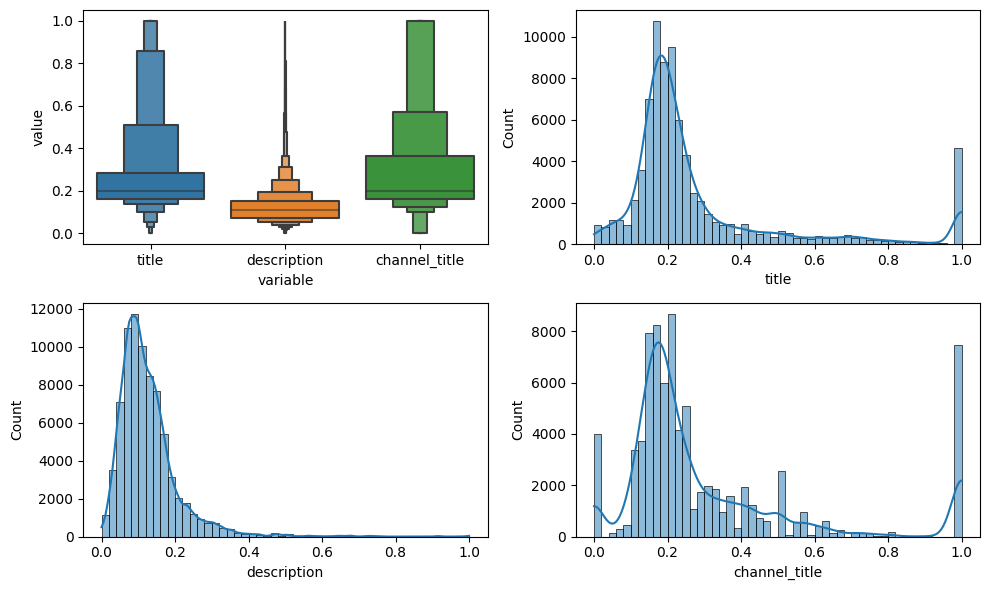

In [52]:
fig, ax = plt.subplots(2,2, figsize=(10,6), dpi=100)
g = sns.boxenplot(data=shouting_df.melt(), x='variable', y='value', ax=ax[0,0])
g = sns.histplot(data=shouting_df[text_features[0]], ax=ax[0,1], kde=True, bins=50)
g = sns.histplot(data=shouting_df[text_features[1]], ax=ax[1,0], kde=True, bins=50)
g = sns.histplot(data=shouting_df[text_features[2]], ax=ax[1,1], kde=True, bins=50)

fig.tight_layout()
plt.show()

Niekt√≥re tytu≈Çy, opisy i nazwy kana≈Ç√≥w o wsp√≥≈Çczyniku shouting ratio > 0.95 

In [53]:
def shouting_gt95(col):
    print(col)
    return videos_df[shouting_df[col] > 0.95][col].value_counts()

In [54]:
shouting_gt95(text_features[0])

title


MY PARENTS DO MY MAKEUP                                               46
NOTHING BEATS A LONDONER                                              43
ADULTS REACT TO KARMA IS A BITCH CHALLENGE                            41
WINNER - ‚ÄòEVERYDAY‚Äô M/V                                               39
CRISTIANO RONALDO E FRED, O GRANDE ENCONTRO                           39
                                                                      ..
COME SHOPPING WITH ME AND TRY ON NEW CLOTHING FOR AUTUMN | VLOG 49     1
KYLIE COSMETICS X KRIS JENNER COLECTION | SWATCHES & DEMO              1
MY PLAN FOR 2018                                                       1
THE SWEATIEST I'VE EVER BEEN!                                          1
17 FUN LIFE HACKS YOU WILL WANT TO TRY YOURSELF                        1
Name: title, Length: 493, dtype: int64

In [55]:
shouting_gt95(text_features[1])

description


ENGLAND V BELGIUM - WORLD CUP 1990 - DAVID PLATT'S  GOAL - 26TH JUNE - BOLGNA, ITALY. IN THE LAST MINUTE OF EXTRA TIME ENGLAND'S DAVID PLATT SCORES WITH A FANTASTIC VOLLEY ON THE TURN FROM PAUL GASCOIGNE'S FREE KICK. A BRILLIANT GOAL IN  A VERY IMPORTANT GAME.    11
SKOL! SKOL! SKOL!                                                                                                                                                                                                                                                        6
BUYING HER OWN ALBUM IN TARGET                                                                                                                                                                                                                                           6
OH BOY                                                                                                                                                                                                 

Widaƒá, ≈ºe nazwa kana≈Çu nie powinna byƒá brana jako 'krzyk' poniewa≈º du≈ºo nazw kana≈Ç√≥w to sƒÖ skr√≥ty nazw w≈ÇƒÖsnych np.: CNN itp.

In [56]:
shouting_gt95(text_features[2])

channel_title


WWE           362
ESPN          334
CNN           305
WIRED         305
SMTOWN        250
             ... 
WE2LITCREW      1
#NAZWA?         1
–¢–°–ù             1
MODSUN          1
M2              1
Name: channel_title, Length: 220, dtype: int64

### Sentiment analysis

Analiza sentymentu przy uzyciu biblioteki TextBlob. Warto≈õci neutralne reprezentowane sƒÖ jako 0, dlatego te≈º widaƒá taki du≈ºy skok w histogramie. Warto≈õci pozytywne sƒÖ ponad 0, a negatywne poni≈ºej (ich si≈Ça wprost proporcjonalna od odleg≈Ço≈õci od 0).

In [58]:
from textblob import TextBlob

def change_sentiment_display(df):
    if df['polarity'] > 0: return 'Positive'
    elif df['polarity'] < 0: return 'Negative'
    elif df['polarity'] == 0: return 'Neutral'

df_temp = videos_df['description'].astype(str)
blobi = []
for sentence in df_temp:
    blob = TextBlob(sentence)
    blobi.append((
        sentence,
        blob.sentiment.polarity,
        blob.sentiment.subjectivity))

df_temp_blob = pd.DataFrame(
    blobi,
    columns = ['sentence', 'polarity', 'subjectivity'])
df_temp_blob['sentiment'] = df_temp_blob.apply(change_sentiment_display, axis=1)

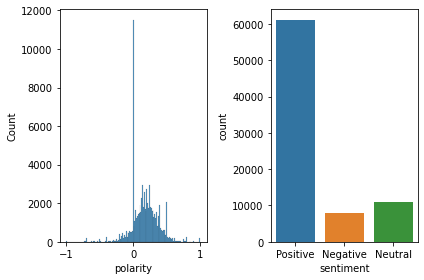

In [59]:
fig, ax = plt.subplots(1,2)
sns.histplot(df_temp_blob, x='polarity', ax = ax[0])
sns.countplot(x="sentiment", data=df_temp_blob, ax = ax[1])
fig.tight_layout()

### Word2Vec embeddings (wbudodowywacze - autorskie t≈Çumaczenie)

Na poczƒÖtku przygotowujemy s≈Çownik sekwencji w celu wytrenowania modelu dla kolumn `description` i `title`.

In [62]:
stopwords_list = list(stopwords.words('english'))   

def clean_text(df_temp, col):
    df_temp = df_temp[col].astype(str)
    sentences = []
    for sentence in df_temp:
        sentence = re.sub(r"http\S+", "", sentence)
        sentence = word_tokenize(re.sub('[^A-Za-z]+', ' ', sentence.lower()))
        sentence_temp = []
        for word in sentence:
            if (word not in stopwords_list) and (len(word) > 2) and not (word.isnumeric()):
                sentence_temp.append(word)
        sentences.append(sentence_temp)
    return sentences

s_description = clean_text(videos_df, 'description')
s_title = clean_text(videos_df, 'title')
print(s_description[:2])

[['shantell', 'channel', 'candice', 'filmed', 'video', 'lens', 'big', 'drone', 'gear', 'sony', 'camera', 'old', 'camera', 'main', 'lens', 'big', 'sony', 'camera', 'big', 'canon', 'camera', 'bendy', 'tripod', 'thing', 'need', 'bendy', 'tripod', 'wide', 'lens', 'expensive', 'wide', 'lens', 'small', 'camera', 'microphone', 'microphone', 'old', 'drone', 'cheaper', 'still', 'great', 'follow', 'amazing', 'intro', 'song', 'disclosure', 'selling', 'promoting', 'anything', 'samsung', 'produce', 'shantell', 'video', 'galaxy', 'project', 'initiative', 'enables', 'creators', 'like', 'shantell', 'make', 'projects', 'might', 'otherwise', 'opportunity', 'make', 'hope', 'clear', 'ask', 'comments', 'answer', 'specifics'], ['one', 'year', 'presidential', 'election', 'john', 'oliver', 'discusses', 'learned', 'far', 'enlists', 'catheter', 'cowboy', 'teach', 'donald', 'trump', 'connect', 'last', 'week', 'tonight', 'online', 'subscribe', 'last', 'week', 'tonight', 'youtube', 'channel', 'almost', 'news', 'al

Trenowanie modelu z wykorzystaniem biblioteki Gensim

In [63]:
model_description = gensim.models.Word2Vec(s_description, iter=100, min_count=5, size=200)
model_title = gensim.models.Word2Vec(s_title, iter=100, min_count=5, size=200)

Przetworzenie danych z datafram√≥w (wykorzystujƒÖc funkcjƒô apply).

In [64]:
def clear_sentence(sentence):
    try:
        sentence = re.sub(r"http\S+", "", sentence)
        sentence = word_tokenize(re.sub('[^A-Za-z]+', ' ', sentence.lower()))
        sentence_temp = []
        for word in sentence:
            if (word not in stopwords_list) and (len(word) > 2) and not (word.isnumeric()):
                sentence_temp.append(word)
        return sentence_temp
    except TypeError:
        return []

descriptions = videos_df.apply(lambda w: clear_sentence(w['description']), axis=1).values
titles = videos_df.apply(lambda w: clear_sentence(w['title']), axis=1).values
descriptions[:2]

array([list(['shantell', 'channel', 'candice', 'filmed', 'video', 'lens', 'big', 'drone', 'gear', 'sony', 'camera', 'old', 'camera', 'main', 'lens', 'big', 'sony', 'camera', 'big', 'canon', 'camera', 'bendy', 'tripod', 'thing', 'need', 'bendy', 'tripod', 'wide', 'lens', 'expensive', 'wide', 'lens', 'small', 'camera', 'microphone', 'microphone', 'old', 'drone', 'cheaper', 'still', 'great', 'follow', 'amazing', 'intro', 'song', 'disclosure', 'selling', 'promoting', 'anything', 'samsung', 'produce', 'shantell', 'video', 'galaxy', 'project', 'initiative', 'enables', 'creators', 'like', 'shantell', 'make', 'projects', 'might', 'otherwise', 'opportunity', 'make', 'hope', 'clear', 'ask', 'comments', 'answer', 'specifics']),
       list(['one', 'year', 'presidential', 'election', 'john', 'oliver', 'discusses', 'learned', 'far', 'enlists', 'catheter', 'cowboy', 'teach', 'donald', 'trump', 'connect', 'last', 'week', 'tonight', 'online', 'subscribe', 'last', 'week', 'tonight', 'youtube', 'channel

U≈õrednienie wektor√≥w Word2Vec z sekwencji

In [65]:
def word_averaging(wv, sequence):
    mean = []
    for word in sequence:
        if word in wv.vocab: mean.append(wv.get_vector(word))
    if not mean: return np.zeros(200,)
    return gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)

def word_averaging_list(wv, sequences):
    return np.vstack([word_averaging(wv, w) for w in sequences])

descriptions = word_averaging_list(model_description.wv, descriptions)
titles = word_averaging_list(model_title.wv, titles)
descriptions[:1]

array([[-3.92003842e-02, -1.87324435e-02, -5.63047118e-02,
         9.99578759e-02, -7.72777349e-02,  2.87484203e-04,
        -5.70680425e-02,  2.08493859e-01, -4.42992449e-02,
        -2.85757463e-02, -3.82351354e-02, -2.03677788e-02,
         5.75085953e-02,  3.77375633e-02,  4.96772155e-02,
        -5.61686084e-02, -7.85354674e-02, -1.11992799e-01,
        -2.47323755e-02, -4.60949615e-02, -7.26852193e-02,
        -5.80711029e-02, -6.19895980e-02,  1.44356694e-02,
         1.08855493e-01,  3.23546827e-02,  5.20860292e-02,
        -5.37622571e-02,  1.55704364e-01,  5.60503080e-02,
        -9.30816308e-02, -5.89439608e-02, -2.34517828e-03,
        -7.27889612e-02, -4.47263122e-02, -6.23323768e-02,
         1.15481772e-01,  4.12472673e-02, -2.69069877e-02,
        -5.81639148e-02,  5.21469712e-02,  9.80437323e-02,
         8.69591683e-02, -3.10405083e-02, -5.00458118e-04,
         6.35508820e-02, -3.21770497e-02,  6.17995523e-02,
        -4.02247943e-02,  1.63472481e-02, -2.35126950e-0

Dodanie kolumn do DataFrame'a

In [66]:
videos_df['description_embedding'] = list(descriptions)
videos_df['title_embedding'] = list(titles)
df.head(5)

video_id trending_date  \
0  2kyS6SvSYSE    2017-11-14   
1  1ZAPwfrtAFY    2017-11-14   
2  5qpjK5DgCt4    2017-11-14   
3  puqaWrEC7tY    2017-11-14   
4  d380meD0W0M    2017-11-14   

                                               title          channel_title  \
0                 WE WANT TO TALK ABOUT OUR MARRIAGE           CaseyNeistat   
1  The Trump Presidency: Last Week Tonight with J...        LastWeekTonight   
2  Racist Superman | Rudy Mancuso, King Bach & Le...           Rudy Mancuso   
3                   Nickelback Lyrics: Real or Fake?  Good Mythical Morning   
4                           I Dare You: GOING BALD!?               nigahiga   

               publish_time  \
0 2017-11-13 17:13:01+00:00   
1 2017-11-13 07:30:00+00:00   
2 2017-11-12 19:05:24+00:00   
3 2017-11-13 11:00:04+00:00   
4 2017-11-12 18:01:41+00:00   

                                                tags    views   likes  \
0                                    SHANtell martin   748374   57527   
1  last week tonight trump presidency|"last week ...  2418783   97185   
2  racist superman|"rudy"|"mancuso"|"king"|"bach"...  3191434  146033   
3  rhett and link|"gmm"|"good mythical morning"|"...   343168   10172   
4  ryan|"higa"|"higatv"|"nigahiga"|"i dare you"|"...  2095731  132235   

   dislikes  comment_count  ... title_word_count  description_word_count  \
0      2966          15954  ...                7                   183.0   
1      6146          12703  ...               10                    93.0   
2      5339           8181  ...                8                    98.0   
3       666           2146  ...                5                   169.0   
4      1989          17518  ...                6                    84.0   

   channel_title_word_count  description_url_count description_url_ratio  \
0                         1                   23.0              0.125683   
1                         1                    4.0              0.043011   
2                         2                   19.0              0.193878   
3                         3                   21.0              0.124260   
4                         1                    7.0              0.083333   

  shouting_ratio_title  shouting_ratio_description  \
0             1.000000                    0.237321   
1             0.220000                    0.068000   
2             0.195122                    0.166464   
3             0.153846                    0.087079   
4             0.705882                    0.051724   

  shouting_ratio_channel_title  \
0                     0.166667   
1                     0.200000   
2                     0.181818   
3                     0.157895   
4                     0.000000   

                               description_embedding  \
0  [-0.03920038416981697, -0.01873244345188141, -...   
1  [0.014761959202587605, 0.04173561558127403, -0...   
2  [-0.020015312358736992, -0.02770298905670643, ...   
3  [-0.06559556722640991, 0.04568478465080261, 0....   
4  [0.005387758836150169, 0.08378226310014725, 0....   

                                     title_embedding  
0  [0.09439771622419357, -0.009736910462379456, -...  
1  [0.04628106579184532, 0.06909669935703278, -0....  
2  [-0.05328453704714775, -0.1283474862575531, -0...  
3  [-0.0035585626028478146, 0.014399386942386627,...  
4  [0.03873312473297119, 0.1384836882352829, -0.0...  

[5 rows x 59 columns]

### Feature hashing

Podej≈õcie, kt√≥re jako≈õciowo mo≈ºna postawiƒá pomiƒôdzy zwyczajnym przydzielaniem etykiet, a OHE. Nie tracimy tyle miejsca co w OHE, bo redukujemy wymiary. Bierzemy warto≈õƒá z kolumny i wykorzystujemy funkcjƒô haszujƒÖcƒÖ do kodowania warto≈õci. Podobny tekst bƒôdzie mia≈Ç podobne wyj≈õcie z funkcji hashujƒÖcej. Jednocze≈õnie wyj≈õcie to mo≈ºemy obciƒÖƒá wiedzƒÖc jaka jest liczno≈õƒá unikalnych warto≈õci w kolumnie (czyli ile bit√≥w bƒôdzie potrzebne, ≈ºeby nie by≈Ço kolizji). W tym przypadku 2027 unikalnych tytu≈Ç√≥w kana≈Ç√≥w mo≈ºna zakodowaƒá na 12 bitach.

In [67]:
def _hash(object, trim):
    obj = hash(object)
    return np.float32(str(obj)[:trim])

for col, trim in zip(['channel_title'], [12]):
    videos_df[col] = videos_df[col].apply(_hash, trim=trim).astype(np.float32)

videos_df.head(5)

video_id trending_date  \
0  2kyS6SvSYSE    2017-11-14   
1  1ZAPwfrtAFY    2017-11-14   
2  5qpjK5DgCt4    2017-11-14   
3  puqaWrEC7tY    2017-11-14   
4  d380meD0W0M    2017-11-14   

                                               title  channel_title  \
0                 WE WANT TO TALK ABOUT OUR MARRIAGE  -7.985698e+10   
1  The Trump Presidency: Last Week Tonight with J...   5.402326e+11   
2  Racist Superman | Rudy Mancuso, King Bach & Le...   3.953746e+11   
3                   Nickelback Lyrics: Real or Fake?   3.667062e+11   
4                           I Dare You: GOING BALD!?  -9.777100e+10   

               publish_time  \
0 2017-11-13 17:13:01+00:00   
1 2017-11-13 07:30:00+00:00   
2 2017-11-12 19:05:24+00:00   
3 2017-11-13 11:00:04+00:00   
4 2017-11-12 18:01:41+00:00   

                                                tags    views   likes  \
0                                    SHANtell martin   748374   57527   
1  last week tonight trump presidency|"last week ...  2418783   97185   
2  racist superman|"rudy"|"mancuso"|"king"|"bach"...  3191434  146033   
3  rhett and link|"gmm"|"good mythical morning"|"...   343168   10172   
4  ryan|"higa"|"higatv"|"nigahiga"|"i dare you"|"...  2095731  132235   

   dislikes  comment_count  ... title_word_count  description_word_count  \
0      2966          15954  ...                7                   183.0   
1      6146          12703  ...               10                    93.0   
2      5339           8181  ...                8                    98.0   
3       666           2146  ...                5                   169.0   
4      1989          17518  ...                6                    84.0   

   channel_title_word_count  description_url_count description_url_ratio  \
0                         1                   23.0              0.125683   
1                         1                    4.0              0.043011   
2                         2                   19.0              0.193878   
3                         3                   21.0              0.124260   
4                         1                    7.0              0.083333   

  shouting_ratio_title  shouting_ratio_description  \
0             1.000000                    0.237321   
1             0.220000                    0.068000   
2             0.195122                    0.166464   
3             0.153846                    0.087079   
4             0.705882                    0.051724   

  shouting_ratio_channel_title  \
0                     0.166667   
1                     0.200000   
2                     0.181818   
3                     0.157895   
4                     0.000000   

                               description_embedding  \
0  [-0.03920038416981697, -0.01873244345188141, -...   
1  [0.014761959202587605, 0.04173561558127403, -0...   
2  [-0.020015312358736992, -0.02770298905670643, ...   
3  [-0.06559556722640991, 0.04568478465080261, 0....   
4  [0.005387758836150169, 0.08378226310014725, 0....   

                                     title_embedding  
0  [0.09439771622419357, -0.009736910462379456, -...  
1  [0.04628106579184532, 0.06909669935703278, -0....  
2  [-0.05328453704714775, -0.1283474862575531, -0...  
3  [-0.0035585626028478146, 0.014399386942386627,...  
4  [0.03873312473297119, 0.1384836882352829, -0.0...  

[5 rows x 59 columns]

# Analiza przydatno≈õci atrybut√≥w